In [5]:
import pyart
import time
import multidop
import tempfile
import pydda
from netCDF4 import Dataset
from copy import deepcopy
from scipy import ndimage
from scipy.interpolate import RegularGridInterpolator, griddata
import warnings
warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cpol_file_path = '/home/rjackson/runtwp1a_cfradial/crsimwrfruntwp1acpolCPOL.a02.20060120.005000.cdf'
cpol2_file_path = '/home/rjackson/runtwp1a_cfradial/crsimwrfruntwp1acpolCPOL2.a02.20060120.005000.cdf'
cpol3_file_path = '/home/rjackson/runtwp1a_cfradial/crsimwrfruntwp1acpolCPOL3.a02.20060120.005000.cdf'
cpol4_file_path = '/home/rjackson/runtwp1a_cfradial/crsimwrfruntwp1acpolCPOL4.a02.20060120.005000.cdf'
berr_file_path = '/home/rjackson/runtwp1a_cfradial/crsimwrfruntwp1acpolBERR.a02.20060120.005000.cdf'
berr_wrf_path = '/home/rjackson/runtwp1a_cfradial/crsimwrfruntwp1acpolinnerBERR.b02.20060120.005000.cdf'
cpol_wrf_path = '/home/rjackson/runtwp1a_cfradial/crsimwrfruntwp1acpolinnerCPOL.b02.20060120.005000.cdf'
wrf_run_path = '/home/rjackson/satoshi_runs/twp1a/wrfout_d01_2006-01-20_00:00:00'

In [150]:
cpol_radar2 = pyart.io.read(cpol2_file_path)
cpol_radar2.latitude['data']

array([-12.4255])

In [151]:
cpol_radar3 = pyart.io.read(cpol2_file_path)
cpol_radar3.latitude['data']

array([-12.4255])

In [152]:
cpol_radar4 = pyart.io.read(cpol2_file_path)
cpol_radar4.latitude['data']

array([-12.4255])

In [97]:
cpol_radar = pyart.io.read(cpol_file_path)
cpol_radar.fields.keys()
berr_radar = pyart.io.read(berr_file_path)
berr_radar.fields['reflectivity']['data'].fill_value

9.96921e+36

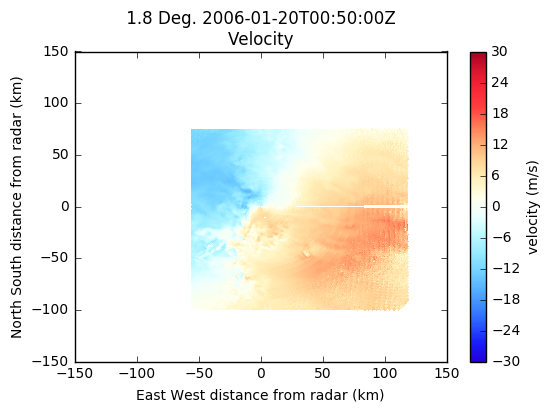

In [7]:
display = pyart.graph.RadarDisplay(cpol_radar)
display.plot_ppi('velocity', sweep=3)

(0, 50)

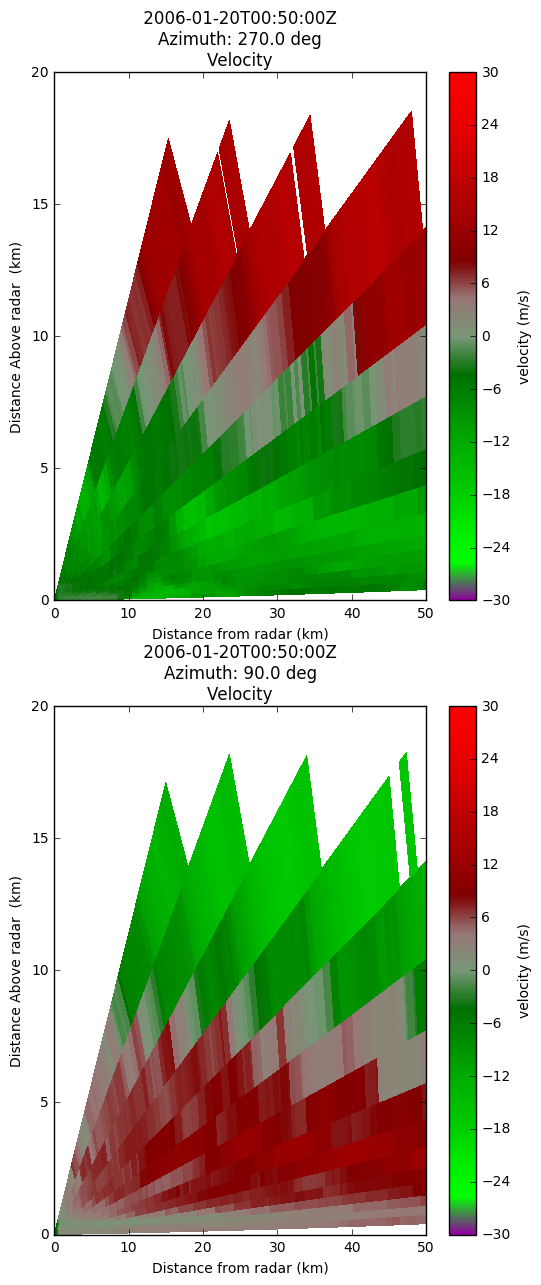

In [8]:
plt.figure(figsize=(6,15))
plt.subplot(211)
display.plot_azimuth_to_rhi('velocity', 270, cmap=pyart.graph.cm.NWSVel)
plt.ylim([0,20])
plt.xlim([0,50])

plt.subplot(212)
display.plot_azimuth_to_rhi('velocity', 90, cmap=pyart.graph.cm.NWSVel)
plt.ylim([0,20])
plt.xlim([0,50])

(0, 60)

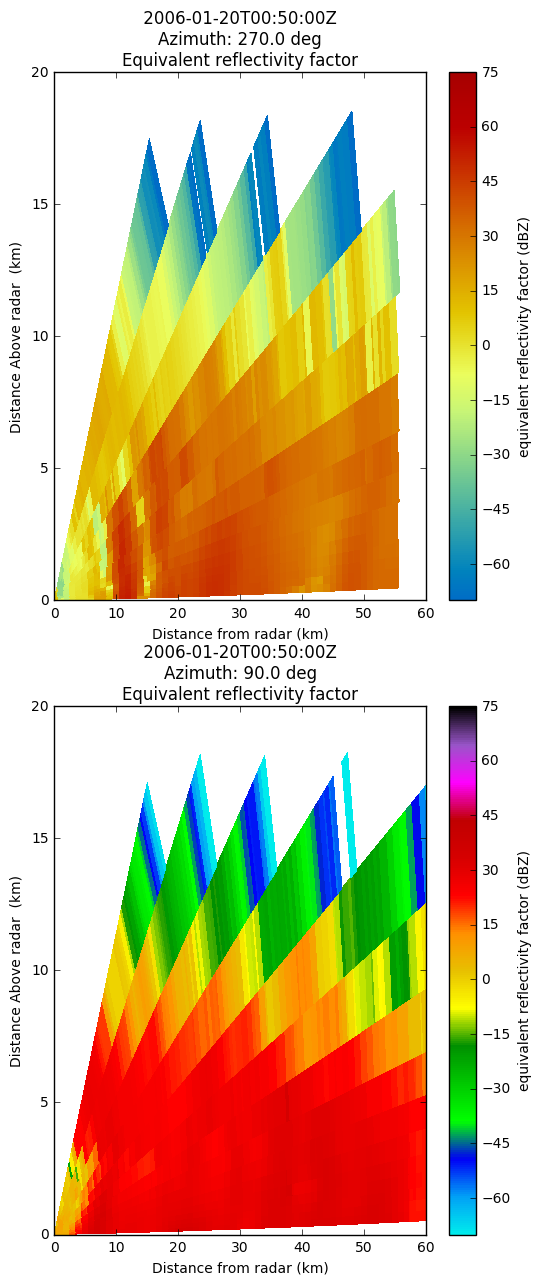

In [9]:
plt.figure(figsize=(6,15))
plt.subplot(211)
display.plot_azimuth_to_rhi('reflectivity', 270, vmin=-70, vmax=75, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
plt.ylim([0,20])
plt.xlim([0,60])

plt.subplot(212)
display.plot_azimuth_to_rhi('reflectivity', 90, vmin=-70, vmax=75, cmap=pyart.graph.cm.NWSRef)
plt.ylim([0,20])
plt.xlim([0,60])

In [99]:
def grid_radar(radar, grid_shape=(20, 301, 301), xlim=(-150000, 150000),
               ylim=(-150000, 150000), zlim=(1000, 20000), bsp=1.0, 
               min_radius=750, h_factor=4.0, nb=1.5,
               fields=['DT', 'VT'], origin=None, gatefilter=False):
    bt = time.time()
    radar_list = [radar]
    if origin is None:
        origin = (radar.latitude['data'][0],
                  radar.longitude['data'][0])
    grid = pyart.map.grid_from_radars(
        radar_list, grid_shape=grid_shape,
        grid_limits=(zlim, ylim, xlim),
        grid_origin=origin, fields=fields,
        weighting_function='Nearest',
        gridding_algo='map_to_grid',
        toa=20000.0,
        h_factor=h_factor,
        min_radius=min_radius,
        bsp=bsp,
        nb=nb, 
        gatefilters=[gatefilter])
    print(time.time() - bt, 'seconds to grid radar')
    return grid

In [153]:
cp = deepcopy(cpol_radar2.fields['reflectivity']['data'])
cpol_radar2.add_field_like('reflectivity', 'DT', cp, replace_existing=True)
cp = deepcopy(cpol_radar2.fields['velocity']['data'])
cpol_radar2.add_field_like('velocity', 'VT', cp, replace_existing=True)

cp = deepcopy(cpol_radar3.fields['reflectivity']['data'])
cpol_radar3.add_field_like('reflectivity', 'DT', cp, replace_existing=True)
cp = deepcopy(cpol_radar3.fields['velocity']['data'])
cpol_radar3.add_field_like('velocity', 'VT', cp, replace_existing=True)

cp = deepcopy(cpol_radar2.fields['reflectivity']['data'])
cpol_radar4.add_field_like('reflectivity', 'DT', cp, replace_existing=True)
cp = deepcopy(cpol_radar4.fields['velocity']['data'])
cpol_radar4.add_field_like('velocity', 'VT', cp, replace_existing=True)

cpol_radar2.fields['DT']['_FillValue'] = 1.0 * cpol_radar2.fields['DT']['data'].fill_value
cpol_radar3.fields['DT']['_FillValue'] = 1.0 * cpol_radar3.fields['DT']['data'].fill_value
cpol_radar4.fields['DT']['_FillValue'] = 1.0 * cpol_radar4.fields['DT']['data'].fill_value

gatefilter_cpol2 = pyart.filters.GateFilter(cpol_radar2)
gatefilter_cpol2.exclude_below('DT', -5)
gatefilter_cpol3 = pyart.filters.GateFilter(cpol_radar3)
gatefilter_cpol3.exclude_below('DT', -5)
gatefilter_cpol4 = pyart.filters.GateFilter(cpol_radar4)
gatefilter_cpol4.exclude_below('DT', -5)

grid_cpol2 = grid_radar(cpol_radar2, 
                        origin=(cpol_radar.latitude['data'][0], cpol_radar.longitude['data'][0]),
                        xlim=(-55000, 50000), ylim=(-50000, 30000), 
                        fields=['DT', 'VT'], 
                        zlim=(0, 20000), grid_shape=(41, 81, 106), min_radius=1500, nb=0.5,
                        bsp=1, h_factor=1, gatefilter=gatefilter_cpol2,
                        )
grid_cpol3 = grid_radar(cpol_radar3, 
                        origin=(cpol_radar.latitude['data'][0], cpol_radar.longitude['data'][0]),
                        xlim=(-55000, 50000), ylim=(-50000, 30000), 
                        fields=['DT', 'VT'], 
                        zlim=(0, 20000), grid_shape=(41, 81, 106), min_radius=1500, nb=0.5,
                        bsp=1, h_factor=1, gatefilter=gatefilter_cpol3,
                        )
grid_cpol4 = grid_radar(cpol_radar4, 
                        origin=(cpol_radar.latitude['data'][0], cpol_radar.longitude['data'][0]),
                        xlim=(-55000, 50000), ylim=(-50000, 30000), 
                        fields=['DT', 'VT'], 
                        zlim=(0, 20000), grid_shape=(41, 81, 106), min_radius=1500, nb=0.5,
                        bsp=1, h_factor=1, gatefilter=gatefilter_cpol4,
                        )

grid_cpol2 = multidop.angles.add_azimuth_as_field(grid_cpol2)
grid_cpol2 = multidop.angles.add_elevation_as_field(grid_cpol2)
grid_cpol3 = multidop.angles.add_azimuth_as_field(grid_cpol3)
grid_cpol3 = multidop.angles.add_elevation_as_field(grid_cpol3)
grid_cpol4 = multidop.angles.add_azimuth_as_field(grid_cpol4)
grid_cpol4 = multidop.angles.add_elevation_as_field(grid_cpol4)

pyart.io.write_grid('cpol2_Darwin_lores.nc', grid_cpol2)
pyart.io.write_grid('cpol3_Darwin_lores.nc', grid_cpol3)
pyart.io.write_grid('cpol4_Darwin_lores.nc', grid_cpol4)

31.629592418670654 seconds to grid radar
31.5067880153656 seconds to grid radar
31.503117561340332 seconds to grid radar


In [154]:
# Change variable names to DT (reflectivity) and VT (velocity) expected by multidop
# If you needed to dealias or perform other corrections,
# this would be the time to start doing that.
# Both datasets already have aliasing corrections
cp = deepcopy(cpol_radar.fields['reflectivity']['data'])

# Apply texture filter to CPOL data
cpol_radar.add_field_like('reflectivity', 'DT', cp, replace_existing=True)
cp = deepcopy(cpol_radar.fields['velocity']['data'])
cpol_radar.add_field_like('velocity', 'VT', cp, replace_existing=True)

cp = deepcopy(berr_radar.fields['reflectivity']['data'])
berr_radar.add_field_like('reflectivity', 'DT', cp, replace_existing=True)
cp = deepcopy(berr_radar.fields['velocity']['data'])
berr_radar.add_field_like('velocity', 'VT', cp, replace_existing=True)

# The analysis engine currently expects the "missing_value" attribute
cpol_radar.fields['DT']['_FillValue'] = 1.0 * cpol_radar.fields['DT']['data'].fill_value
berr_radar.fields['DT']['_FillValue'] = 1.0 * berr_radar.fields['DT']['data'].fill_value
cpol_radar.fields['VT']['_FillValue'] = 1.0 * cpol_radar.fields['VT']['data'].fill_value
berr_radar.fields['VT']['_FillValue'] = 1.0 * berr_radar.fields['VT']['data'].fill_value

cpol_radar.fields['DT']['missing_value'] = 1.0 * cpol_radar.fields['DT']['data'].fill_value
berr_radar.fields['DT']['missing_value'] = 1.0 * berr_radar.fields['DT']['data'].fill_value
cpol_radar.fields['VT']['missing_value'] = 1.0 * cpol_radar.fields['VT']['data'].fill_value
berr_radar.fields['VT']['missing_value'] = 1.0 * berr_radar.fields['VT']['data'].fill_value

gatefilter_cpol = pyart.filters.GateFilter(cpol_radar)
gatefilter_cpol.exclude_below('DT', -5)
gatefilter_berr = pyart.filters.GateFilter(berr_radar)
gatefilter_berr.exclude_below('DT', -5)

# Grid the data to a Cartesian grid. The Dual doppler domain does not extend ~60 km 
# from both radars, so no need to store more data than that. 
grid_cpol = grid_radar(cpol_radar, 
                       origin=(cpol_radar.latitude['data'][0], cpol_radar.longitude['data'][0]),
                       xlim=(-55000, 50000), ylim=(-50000, 30000), 
                       fields=['DT', 'VT'], 
                       zlim=(0, 20000), grid_shape=(41, 81, 106), min_radius=1500, nb=0.5,
                       bsp=1, h_factor=1,
                       gatefilter=gatefilter_cpol,
                       )
grid_Berr = grid_radar(berr_radar, 
                       origin=(cpol_radar.latitude['data'][0], cpol_radar.longitude['data'][0]),
                       fields=['DT', 'VT'],
                       xlim=(-55000, 50000), ylim=(-50000, 30000), min_radius=1500, nb=0.5, 
                       bsp=0.5, h_factor=1,
                       zlim=(0, 20000),   
                       grid_shape=(41, 81, 106),
                       gatefilter=gatefilter_berr,
                       )

# The analysis engine requires azimuth and elevation to be part of the grid.
# This information is computed from the grid geometry.
grid_cpol = multidop.angles.add_azimuth_as_field(grid_cpol)
grid_Berr = multidop.angles.add_azimuth_as_field(grid_Berr)
grid_cpol = multidop.angles.add_elevation_as_field(grid_cpol)
grid_Berr = multidop.angles.add_elevation_as_field(grid_Berr)

# Save the input grids for later.
pyart.io.write_grid('cpol_Darwin_lores.nc', grid_cpol)
pyart.io.write_grid('berr_Darwin_lores.nc', grid_Berr)

45.00469517707825 seconds to grid radar
43.76040601730347 seconds to grid radar


In [3]:
grid_cpol = pyart.io.read_grid('cpol_Darwin.nc')
grid_cpol2 = pyart.io.read_grid('cpol2_Darwin.nc')
grid_cpol3 = pyart.io.read_grid('cpol3_Darwin.nc')
grid_cpol4 = pyart.io.read_grid('cpol_Darwin.nc')
grid_Berr = pyart.io.read_grid('berr_Darwin.nc')

(0, 20)

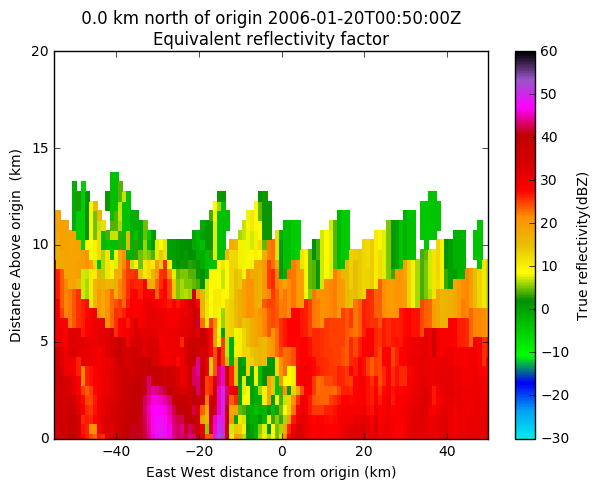

In [226]:
level = 50
fig1 = plt.figure(figsize=(7,5))
CPOLGridDisplay = pyart.graph.GridMapDisplay(grid_cpol2)
CPOLGridDisplay.plot_latitudinal_level('DT', level,
                                       cmap=pyart.graph.cm.NWSRef,
                                       vmin=-30, vmax=60)                           

plt.xlim([-55, 50])
plt.ylim([0, 20])

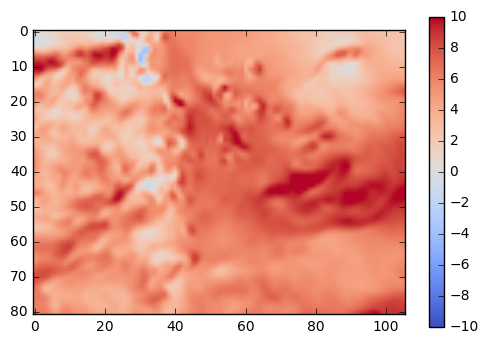

In [17]:
plt.imshow(u_init[10,:,:], cmap='coolwarm', vmin=-10, vmax=10)
plt.colorbar()

(0, 20)

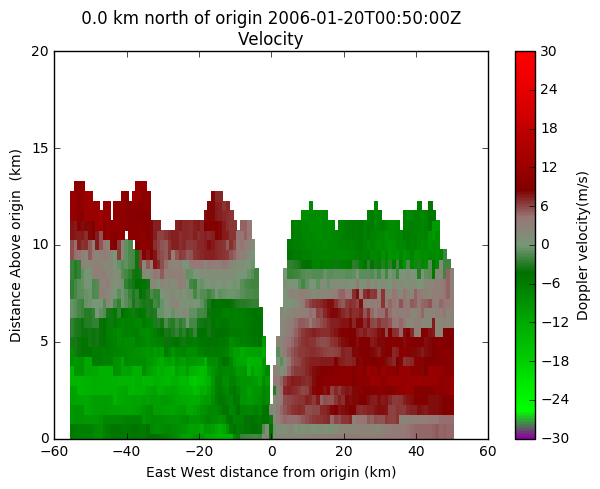

In [58]:
level = 50
fig1 = plt.figure(figsize=(7,5))
CPOLGridDisplay = pyart.graph.GridMapDisplay(grid_cpol)
CPOLGridDisplay.plot_latitudinal_level('VT', level,
                                       cmap=pyart.graph.cm.NWSVel,
                                       vmin=-30, vmax=30)                           

plt.xlim([-60, 60])
plt.ylim([0,20])

(-40, 40)

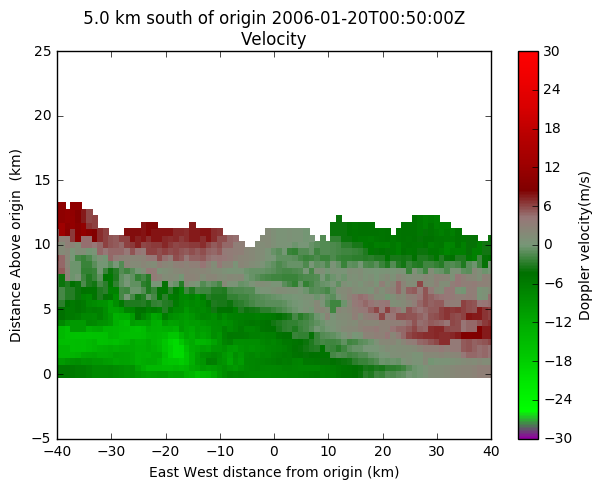

In [25]:
level = 45
fig1 = plt.figure(figsize=(7,5))
CPOLGridDisplay = pyart.graph.GridMapDisplay(grid_Berr)
CPOLGridDisplay.plot_latitudinal_level('VT', level,
                                       cmap=pyart.graph.cm.NWSVel,
                                       vmin=-30, vmax=30)                           

plt.xlim([-40, 40])

In [422]:
print(grid_cpol.z)

{'long_name': 'Z distance on the projection plane from the origin', 'standard_name': 'projection_z_coordinate', 'positive': 'up', 'data': array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
        8000.,  9000., 10000., 11000., 12000., 13000., 14000., 15000.,
       16000., 17000., 18000., 19000., 20000.]), 'units': 'm', 'axis': 'Z'}


In [139]:
# You don't have to define everything. Most of these keywords are default values.
# If you don't define something the program will provide a default value.
# Check parameters.py for what keyword default values are.
localfile = tempfile.NamedTemporaryFile()
pd = {'dir': './',
      'x': [-55000.0, 1000.0, 106],   # start, step, max = min + (steps-1)
      'y': [-50000.0, 1000.0, 81],
      'z': [0.0, 500.0,  41],
      'grid': [grid_cpol.origin_longitude['data'][0], grid_cpol.origin_latitude['data'][0], 50.0],
      'files': ['cpol_Darwin.nc',  
                'berr_Darwin.nc'],
      'radar_names': ['Berrima', 'CPOL1', 'CPOL2', 'CPOL'],
      'refl': 'DT',  # Name of reflectivity field. Must be common between radars.
      'vt': 'VT',  # Name of velocity field. Must be common between radars.
      'bgfile': 'sounding_file', # Name of sounding file
      'writeout': localfile.name, # Name of output grid file
      'min_cba': 30.0,  # Minimum beam-crossing angle
      'calc_params': 'cpol_calc.dda', # .dda file for parameters related to minimization routine
      'anel': 1, # 0 = Boussinesq approximation for mass conservation, 1 = anelastic 
      'laplace': 0, # 0 = 1st order derivatives for smoothing, 1 = second
      'read_dataweights': 2, # 0 = calculate data constraint weights/output, 1 = read from file, 2 = weigh all equally
      'max_dist': 10.0, # How much distance analysis and observational grid must match in m
      'cutoff': 0.0, # Deny observations below this level from analysis (m)
      'UT': 0.0, # U of prescribed storm motion vector
      'VT': 0.0, # V of prescribed storm motion vector
      'output_error': 0, # 1 = output verification stats after each iteration
      'weak_height': -1, # Sounding height constraint weakened in regions > 10 dBZ below this height (-1 = disabled)
      'upper_bc': 1, # 1 = w = 0 as upper boundary condition, -1 = ignore
      'itmax_frprmn': [200, 10], # max iterations in frprmn function
      'itmax_dbrent': 200, # max iterations in dbrent function
      'C1b': 1.0,  # Data weighting factor
      'C2b': 1500.0,  # Mass continuity weighting factor
      'C3b': 0.0,  # Vorticity weighting factor
      'C4b': 0.0,  # Horizontal smoothing factor
      'C5b': 0.0,  # Vertical smoothing factor
      'C8b': 0.001,  # Sounding factor
      'vary_weights': 0,
      # Define filter with ONE of the following forms.
      # filter: None,
      # filter: filter_frequency Leise nstep
      # filter: filter_frequency low-pass alpha
      'filter': ['60', 'Leise', '2'],
      # Coverage values for various combinations of radars.
      # Each line should provide the type of coverage value, radar count,
      # radar names, and the value, in the following form:
      #
      #   cvg_(""|opt|sub)_(bg|fil): integer radar1 radar2 ... boolean
      #
      # Radars are identified by the OPAWS/OBAN file name with grid data for that
      # radar. This must be just the base name, not the full path.
      #
      # For example:
      #
      #   cvg_opt_bg: SR1 SR2 1
      #
      # says that if SR1 SR2
      # both have data within max_dist meters of the point under consideration,
      # and an optimal beam crossing angle, then the point will receive a coverage
      # value of 1, i.e. point has coverage.
      #
      # "opt" means optimal beam crossing angle.
      # "sub" means suboptimal beam crossing angle.
      # "bg" means background coverage.
      # "fil" means filter coverage.
      # cvg_bg, cvg_fil, and sseq_trip do not require a radar count. (Beam crossing
      # angle is meaningless with one radar, so there is no opt or sub)
      #
      # If this file is being used, coverage values must be provided for all
      # combinations of radars.
      'cvg_opt_bg': [1, 1, 1],
      'cvg_sub_bg': [1, 1, 1],
      'cvg_opt_fil': [0, 0, 0],
      'cvg_sub_fil': [1, 1, 1],
      'cvg_bg': [1, 1, 1],
      'cvg_fil': [0, 0, 0],
      'sseq_trip': [1.0, 1.0, 1.0]
     }
pf = multidop.parameters.ParamFile(pd, 'cpol_test.dda')
pf = multidop.parameters.CalcParamFile(pd, 'cpol_calc.dda')

In [140]:
# Unfortunately, text output from the analysis engine (DDA) will not display
# until after the program completes. Expect this step to take several minutes.
bt = time.time()
multidop.execute.do_analysis('cpol_test.dda', cmd_path='/home/rjackson/multidop/src/DDA')
print((time.time()-bt)/60.0, 'minutes to process')

DDA 0.9.0
./DDA: reading calculation parameters from cpol_calc.dda.
Changing working directory to ./
x: -55000.000000 to 50000.000000 in 105 steps of 1000.000000
y: -50000.000000 to 30000.000000 in 80 steps of 1000.000000
z: 0.000000 to 20000.000000 in 40 steps of 500.000000
z_min=0, cutoff=0
UT=0, VT=0
Anelastic mass cons
First-order smoothness constraint
Minimum beam crossing angle = 30 degrees
Py-ART grids for analyis and all radars must match to within (dx, dy, dz) < (10 10 10) meters.
Reading Py-ART filecpol_Darwin.nc
berr_Darwin.nc

Radar positions:  (-0.728344,-0.0129925) (-0.727681,-26557.7)
Computing coverage: 194406 verification points out of 352026 total points.
radar0 197209 obs. radar1 197468 obs. 394677 total obs.
Reading sounding file sounding_file
k        z     USND     VSND |  k        z     USND     VSND
0      0.0     -3.8      3.3 | 20  10000.0     -6.2      5.7
1    500.0     -1.5     -5.4 | 21  10500.0     -8.9      7.4
2   1000.0      0.7     -7.0 | 22  11000.0 

In [141]:
# Baseline output is not CF or Py-ART compliant. This function fixes that.
# This is why we wrote the original output to a tempfile that can be safely removed.
# The final grid will have all wind solutions outside the coverage region masked.
fname = 'cf_compliant_grid.nc'
final_grid = multidop.grid_io.make_new_grid([grid_cpol, grid_Berr], 
                                            localfile.name,
                                            use_mask=True,
                                            min_refl=-40.0)
final_grid.write(fname)
localfile.close()
pyart_grid = pyart.io.read_grid(fname)
print(pyart_grid.fields.keys())

dict_keys(['northward_wind', 'reflectivity', 'upward_air_velocity', 'eastward_wind'])


In [119]:
dir(pydda.retrieval)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'angles',
 'get_bca',
 'get_dd_wind_field',
 'wind_retrieve']

## Use these cells to activate PyDDA based retrieval!

In [4]:
sounding_file_path = '/home/rjackson/data/soundings/twpsondewnpnC3.b1.20060120.043800.custom.cdf'
sounding = pyart.io.read_arm_sonde(sounding_file_path)
#u_init, v_init, w_init = pydda.initialization.make_wind_field_from_profile(
#            grid_cpol, sounding, vel_field='VT')
#u_init, v_init, w_init = pydda.initialization.make_constant_wind_field(grid_cpol, (0.0,0.0,0.0), vel_field='VT')
u_init, v_init, w_init = pydda.initialization.make_background_from_wrf(grid_cpol, wrf_run_path, 
                                                                       datetime.datetime(2006,1,20,0,50,0),
                                                                       (56,100), vel_field='VT')
Grids = pydda.retrieval.get_dd_wind_field(
            [grid_cpol, grid_Berr], u_init, v_init, w_init, 
            Co=1.0, Cm=1500.0, Cv=0.0, Ut=0.0, Vt=0.0,
            Cz=0, vel_name='VT', refl_field='DT',
            frz=5000.0, filt_iterations=0,  mask_outside_opt=True, upper_bc=1)
pyart.io.write_grid('pydda_test_grid.nc', Grids[0]) 

ValueError: shape mismatch: objects cannot be broadcast to a single shape

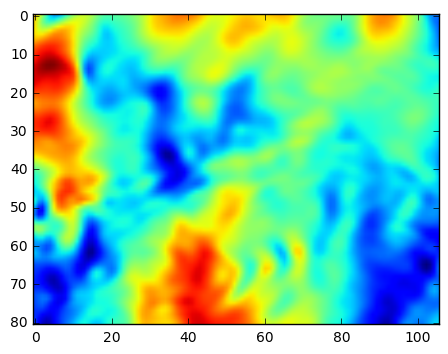

In [85]:
imshow(u_init[30,:,:])

In [145]:
fname = 'pydda_test_grid.nc'
pyart_grid = pyart.io.read_grid(fname)
print(pyart_grid.fields.keys())

dict_keys(['VT', 'ROI', 'AZ', 'u', 'DT', 'v', 'EL', 'w'])


In [142]:
fname = 'cf_compliant_grid.nc'
pyart_grid_mdop = pyart.io.read_grid(fname)
print(pyart_grid_mdop.fields.keys())

dict_keys(['northward_wind', 'reflectivity', 'upward_air_velocity', 'eastward_wind'])


In [21]:
def get_bca(grid):
    berr_origin = [-0.727681,-26557.7]
    x,y = np.meshgrid(grid.x['data'], grid.y['data'])
    a = np.sqrt(np.multiply(x,x)+np.multiply(y,y))
    b = np.sqrt(pow(x-berr_origin[0],2)+pow(y-berr_origin[1],2))
    c = np.sqrt(berr_origin[0]*berr_origin[0]+berr_origin[1]*berr_origin[1])
    theta_1 = np.arccos(x/a)
    theta_2 = np.arccos((x-berr_origin[1])/b)
    return np.arccos((a*a+b*b-c*c)/(2*a*b))

def get_bca_rads(grid, radar1_origin, radar2_origin):
    x,y = np.meshgrid(grid.x['data'], grid.y['data'])
    x = x-radar1_origin[0]
    y = y-radar1_origin[1]
    radar2_origin = radar2_origin-radar1_origin
    a = np.sqrt(np.multiply(x,x)+np.multiply(y,y))
    b = np.sqrt(pow(x-radar2_origin[0],2)+pow(y-radar2_origin[1],2))
    c = np.sqrt(radar2_origin[0]*radar2_origin[0]+radar2_origin[1]*radar2_origin[1])
    theta_1 = np.arccos(x/a)
    theta_2 = np.arccos((x-radar2_origin[1])/b)
    return np.arccos((a*a+b*b-c*c)/(2*a*b))

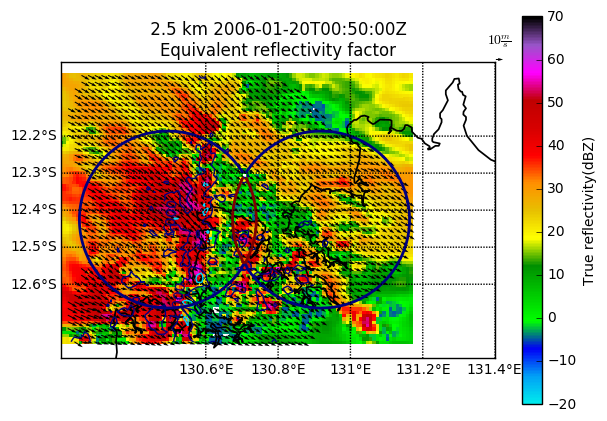

In [34]:
level = 5
fig1 = plt.figure(figsize=(7,5))
CPOLGridDisplay = pyart.graph.GridMapDisplay(pyart_grid)
CPOLGridDisplay.plot_basemap(min_lat=-12.8, max_lat=-12.0,
                             min_lon=130.2, max_lon=131.4,
                             auto_range=False,
                             lat_lines=[-12.6, -12.5, -12.4, -12.3, -12.2, -12.0],
                             lon_lines=[130.6, 130.8, 131.0, 131.2, 131.4],
                             resolution='h')
CPOLGridDisplay.plot_grid('DT', level, vmin=-20, vmax=70,
                          cmap=pyart.graph.cm.NWSRef)

lons, lats = pyart_grid.get_point_longitude_latitude(level=level)
v = pyart_grid.fields['v']['data'][level,::2,::2]
u = pyart_grid.fields['u']['data'][level,::2,::2]
w = pyart_grid.fields['w']['data'][level]
Wcomp = np.amax(pyart_grid.fields['w']['data'], axis=0)

q = CPOLGridDisplay.basemap.quiver(lons[::2,::2], lats[::2,::2], 
                                   u, v, 
                                   scale=600,
                                   latlon='True')
qk = plt.quiverkey(q, 1.01, 1.01, 10, r'$10  \frac{m}{s}$',
                   fontproperties={'weight': 'bold'})
CS = CPOLGridDisplay.basemap.contour(lons, lats,
                                     w, latlon='True',
                                     levels=[1, 4, 6, 10])
plt.clabel(CS, inline=1, fontsize=10)
bca = get_bca(pyart_grid)

CSa = CPOLGridDisplay.basemap.contour(lons, lats,
                                      bca, latlon='True',
                                      levels=[math.pi/6, 5*math.pi/6],
                                      linewidths=2)

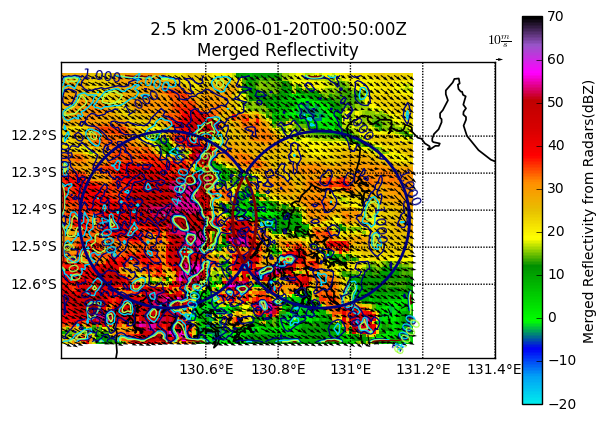

In [38]:
level = 5
fig1 = plt.figure(figsize=(7,5))
CPOLGridDisplay = pyart.graph.GridMapDisplay(pyart_grid_mdop)
CPOLGridDisplay.plot_basemap(min_lat=-12.8, max_lat=-12.0,
                             min_lon=130.2, max_lon=131.4,
                             auto_range=False,
                             lat_lines=[-12.6, -12.5, -12.4, -12.3, -12.2, -12.0],
                             lon_lines=[130.6, 130.8, 131.0, 131.2, 131.4],
                             resolution='h')
CPOLGridDisplay.plot_grid('reflectivity', level, vmin=-20, vmax=70,
                          cmap=pyart.graph.cm.NWSRef)

lons, lats = pyart_grid.get_point_longitude_latitude(level=level)
v = pyart_grid_mdop.fields['northward_wind']['data'][level,::2,::2]
u = pyart_grid_mdop.fields['eastward_wind']['data'][level,::2,::2]
w = pyart_grid_mdop.fields['upward_air_velocity']['data'][level]
Wcomp = np.amax(pyart_grid_mdop.fields['upward_air_velocity']['data'], axis=0)

q = CPOLGridDisplay.basemap.quiver(lons[::2,::2], lats[::2,::2], 
                                   u, v, 
                                   scale=600,
                                   latlon='True')
qk = plt.quiverkey(q, 1.01, 1.01, 10, r'$10  \frac{m}{s}$',
                   fontproperties={'weight': 'bold'})
CS = CPOLGridDisplay.basemap.contour(lons, lats,
                                     w, latlon='True',
                                     levels=[1, 4, 6, 10])
plt.clabel(CS, inline=1, fontsize=10)
bca = get_bca(pyart_grid)

CSa = CPOLGridDisplay.basemap.contour(lons, lats,
                                      bca, latlon='True',
                                      levels=[math.pi/6, 5*math.pi/6],
                                      linewidths=2)

(-50, 50)

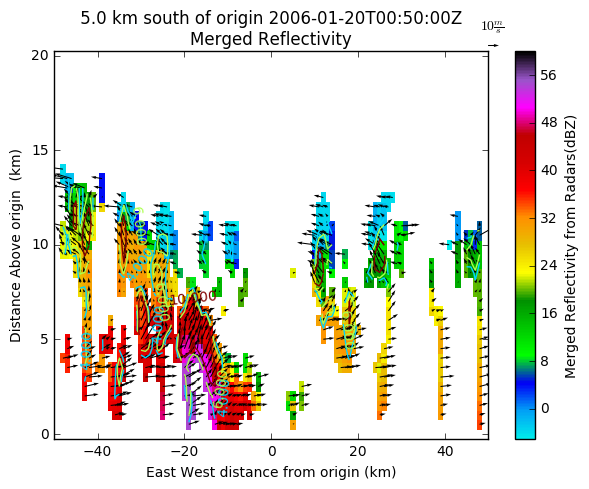

In [36]:
level = 45
fig1 = plt.figure(figsize=(7,5))
CPOLGridDisplay = pyart.graph.GridMapDisplay(pyart_grid_mdop)
pyart_grid_mdop.fields['reflectivity']['data'] = np.ma.masked_where(pyart_grid_mdop.fields['eastward_wind']['data'].mask == True,
                                                               pyart_grid_mdop.fields['reflectivity']['data'])
CPOLGridDisplay.plot_latitudinal_level('reflectivity', level,
                                       cmap=pyart.graph.cm.NWSRef,
                                       vmin=-5, vmax=60)                           

X,Y = np.meshgrid(pyart_grid.x['data']/1e3, pyart_grid.z['data']/1e3)
v = pyart_grid_mdop.fields['upward_air_velocity']['data'][:,level,:]
u = pyart_grid_mdop.fields['eastward_wind']['data'][:,level,:]
q = plt.quiver(X[:,:], Y[:,:], u[:,:], v[:,:], scale=400)
qk = plt.quiverkey(q, 1.01, 1.015, 10, r'$10  \frac{m}{s}$',
                   fontproperties={'weight': 'bold'})
CS = plt.contour(X,Y, v, levels=[1,4,6,10])
plt.clabel(CS, inline=1, fontsize=10)
plt.xlim([-50, 50])

In [6]:
wrf_cdf = Dataset(wrf_run_path, mode='r')
Z_wrf = wrf_cdf.variables['REFL_10CM'][:,:,:,:]
Lat_wrf = wrf_cdf.variables['XLAT'][:,:,:]
Lon_wrf = wrf_cdf.variables['XLONG'][:,:,:]
W_wrf = wrf_cdf.variables['W'][:]
V_wrf = wrf_cdf.variables['V'][:]
U_wrf = wrf_cdf.variables['U'][:]
PH_wrf = wrf_cdf.variables['PH'][:]
PHB_wrf = wrf_cdf.variables['PHB'][:]
ETA_wrf = wrf_cdf.variables['ZNW'][:]
array_shape = PH_wrf.shape
alt_wrf = (PH_wrf+PHB_wrf)/9.81
print(dir(wrf_cdf))
print(wrf_cdf.__getattribute__('SOUTH-NORTH_GRID_DIMENSION'))

['AER_ANGEXP_OPT', 'AER_ANGEXP_VAL', 'AER_AOD550_OPT', 'AER_AOD550_VAL', 'AER_ASY_OPT', 'AER_ASY_VAL', 'AER_OPT', 'AER_SSA_OPT', 'AER_SSA_VAL', 'AER_TYPE', 'BLDT', 'BL_PBL_PHYSICS', 'BOTTOM-TOP_GRID_DIMENSION', 'BOTTOM-TOP_PATCH_END_STAG', 'BOTTOM-TOP_PATCH_END_UNSTAG', 'BOTTOM-TOP_PATCH_START_STAG', 'BOTTOM-TOP_PATCH_START_UNSTAG', 'BUCKET_J', 'BUCKET_MM', 'CEN_LAT', 'CEN_LON', 'CUDT', 'CU_PHYSICS', 'DAMPCOEF', 'DAMP_OPT', 'DFI_OPT', 'DIFF_6TH_FACTOR', 'DIFF_6TH_OPT', 'DIFF_OPT', 'DT', 'DX', 'DY', 'FEEDBACK', 'GFDDA_END_H', 'GFDDA_INTERVAL_M', 'GMT', 'GRAV_SETTLING', 'GRIDTYPE', 'GRID_FDDA', 'GRID_ID', 'GRID_SFDDA', 'HYPSOMETRIC_OPT', 'ICLOUD', 'ICLOUD_CU', 'ISFFLX', 'ISFTCFLX', 'ISHALLOW', 'ISICE', 'ISLAKE', 'ISOILWATER', 'ISURBAN', 'ISWATER', 'I_PARENT_START', 'JULDAY', 'JULYR', 'J_PARENT_START', 'KHDIF', 'KM_OPT', 'KVDIF', 'MAP_PROJ', 'MAP_PROJ_CHAR', 'MFSHCONV', 'MMINLU', 'MOAD_CEN_LAT', 'MOIST_ADV_OPT', 'MP_PHYSICS', 'NUM_LAND_CAT', 'OBS_NUDGE_OPT', 'PARENT_GRID_RATIO', 'PARENT_I

In [215]:
print(wrf_cdf.variables['W'])
print(alt_wrf.shape)
times = wrf_cdf.variables['Times']
print(''.join([x.decode() for x in times[0]]))

<class 'netCDF4._netCDF4.Variable'>
float32 W(Time, bottom_top_stag, south_north, west_east)
    FieldType: 104
    MemoryOrder: XYZ
    description: z-wind component
    units: m s-1
    stagger: Z
    coordinates: XLONG XLAT XTIME
unlimited dimensions: Time
current shape = (18, 97, 174, 174)
filling on, default _FillValue of 9.969209968386869e+36 used

(18, 97, 174, 174)
2006-01-20_00:00:00


In [28]:
def get_bca_wrf(x,y):
    cpol_origin = np.array([56, 100])-87
    berr_origin = np.array([56, 74])-87-cpol_origin
    x = x-cpol_origin[0]
    y = y-cpol_origin[1]
    a = np.sqrt(np.multiply(x,x)+np.multiply(y,y))
    b = np.sqrt(pow(x-berr_origin[0],2)+pow(y-berr_origin[1],2))
    c = np.sqrt(berr_origin[0]*berr_origin[0]+berr_origin[1]*berr_origin[1])
    theta_1 = np.arccos(x/a)
    theta_2 = np.arccos((x-berr_origin[1])/b)
    return np.arccos((a*a+b*b-c*c)/(2*a*b))

(18, 97, 174, 174)


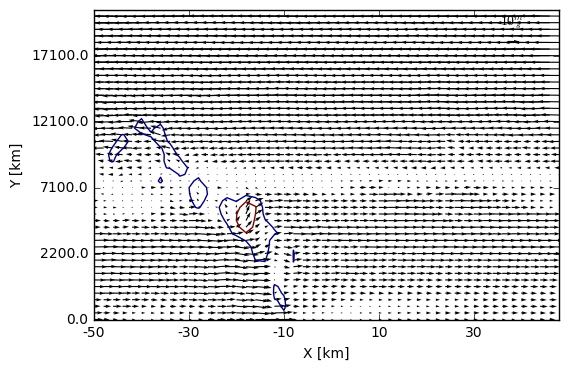

In [13]:
print(W_wrf.shape)
cpol_x = 56
cpol_y = 100
w = W_wrf[5,:-1,cpol_y-5,cpol_x-50:cpol_x+50]
v = V_wrf[5,:,cpol_y-5,cpol_x-50:cpol_x+50]
u = U_wrf[5,:,cpol_y-5,cpol_x-50:cpol_x+50]
z = Z_wrf[5,:,cpol_y-5,cpol_x-50:cpol_x+50]
alt = alt_wrf[4,:,87-40:87+40,87]
lat = Lat_wrf[:,87-40:87+40,87]
x, y, z = np.meshgrid(np.arange(-40, 40, 1), np.arange(-40, 40, 1), np.arange(0,97,1))
q= plt.quiver(u[::2,::2], w[::2,::2], scale=400)
qk = plt.quiverkey(q, 0.9, 0.9, 10, r'$10  \frac{m}{s}$',
                   fontproperties={'weight': 'bold'})
plt.contour(w[::2,::2], levels=[1,4])
plt.xticks(range(0,50,10), [str(2*x-50) for x in np.arange(0,50,10)])
plt.yticks(range(0,50,10), [str(round(np.mean(alt[2*x]),-2)) for x in np.arange(0,50,10)])
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
#plt.colorbar()

(18, 97, 174, 174)
(96,)


/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1472: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  x0 = ma.minimum(x)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1473: DeprecationWarning: Single-argument form of np.ma.maximum is deprecated. Use np.ma.maximum.reduce instead.
  x1 = ma.maximum(x)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


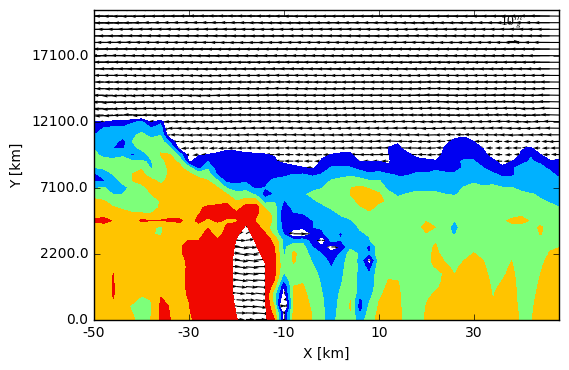

In [46]:
print(W_wrf.shape)
cpol_x = 56
cpol_y = 100
w = W_wrf[5,:-1,cpol_y-5,cpol_x-50:cpol_x+50]
v = V_wrf[5,:,cpol_y-5,cpol_x-50:cpol_x+50]
u = U_wrf[5,:,cpol_y-5,cpol_x-50:cpol_x+50]
zs = Z_wrf[5,:,cpol_y-5,cpol_x-50:cpol_x+50]
print(z.shape)
alt = alt_wrf[4,:,87-40:87+40,87]
lat = Lat_wrf[:,87-40:87+40,87]
x, y, z = np.meshgrid(np.arange(-40, 40, 1), np.arange(-40, 40, 1), np.arange(0,97,1))
q= plt.quiver(u[::2,::2], w[::2,::2], scale=400)
qk = plt.quiverkey(q, 0.9, 0.9, 10, r'$10  \frac{m}{s}$',
                   fontproperties={'weight': 'bold'})
plt.contourf(zs[::2, ::2], levels=[0, 10, 20, 30, 40, 50])
plt.xticks(range(0,50,10), [str(2*x-50) for x in np.arange(0,50,10)])
plt.yticks(range(0,50,10), [str(round(np.mean(alt[2*x]),-2)) for x in np.arange(0,50,10)])
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
#plt.colorbar()

In [8]:
scale_down_horiz = 1
scale_down_vert = 1
w = W_wrf[5,:-1,:,:]
v = V_wrf[5,:,:-1,:]
u = U_wrf[5,:,:,:-1]
z = Z_wrf[5,:,:,:]
new_grid_x, new_grid_y, new_grid_z = np.meshgrid(range(-87,87,scale_down_horiz), 
                                                 range(-87,87,scale_down_horiz), 
                                                 np.arange(0,20000,500*scale_down_vert))
x = range(-87,87,1)
y = range(-87,87,1)
z = alt_wrf[4,:-1,1,1]
print(v.shape)
w_new = griddata((z, y, x), w, (new_grid_z, new_grid_y, new_grid_x))
v_interp = RegularGridInterpolator((z, y, x), v)
u_interp = RegularGridInterpolator((z, y, x), u)
z_interp = RegularGridInterpolator((z, y, x), Z_wrf[4,:,:,:])

(96, 174, 174)


TypeError: griddata() missing 2 required positional arguments: 'xi' and 'yi'

/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1472: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  x0 = ma.minimum(x)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1473: DeprecationWarning: Single-argument form of np.ma.maximum is deprecated. Use np.ma.maximum.reduce instead.
  x1 = ma.maximum(x)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


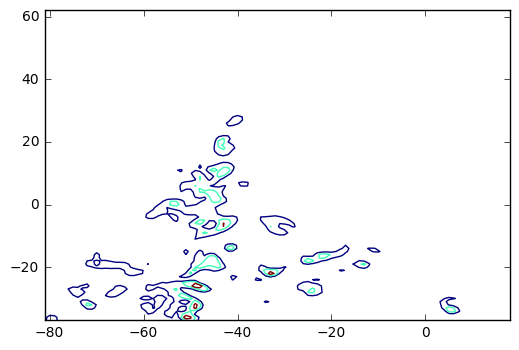

In [48]:
plt.contour(new_grid_x[int((cpol_y-50)/scale_down_horiz):int((cpol_y+50)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),6], 
            new_grid_y[int((cpol_y-50)/scale_down_horiz):int((cpol_y+50)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),6],
            w_new[int((cpol_y-50)/scale_down_horiz):int((cpol_y+50)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),6],levels=[1,4,8])


(174, 174, 40)


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in arccos
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1472: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  x0 = ma.minimum(x)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence

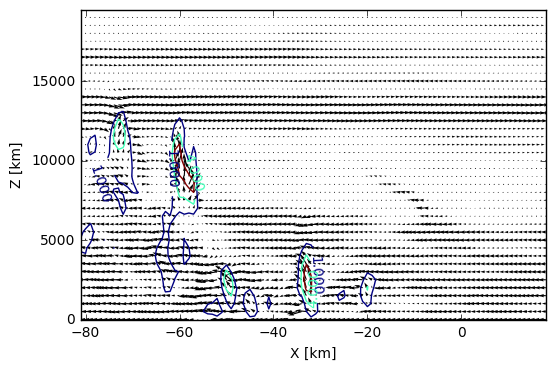

In [49]:
w_new = w_interp((new_grid_z, new_grid_y, new_grid_x))
v_new = v_interp((new_grid_z, new_grid_y, new_grid_x))
u_new = u_interp((new_grid_z, new_grid_y, new_grid_x))
z_new = z_interp((new_grid_z, new_grid_y, new_grid_x))
bca_wrf = get_bca_wrf(new_grid_x, new_grid_y)
print(u_new.shape)
plt.quiver(new_grid_x[int((cpol_y-35)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:], 
           new_grid_z[int((cpol_y-35)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:], 
           v_new[int((cpol_y-35)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:], 
           w_new[int((cpol_y-35)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:])
CS = plt.contour(new_grid_x[int((cpol_y-35)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:], 
            new_grid_z[int((cpol_y-35)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:],
            w_new[int((cpol_y-35)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:],levels=[1,4,8])
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('X [km]')
plt.ylabel('Z [km]')

(174, 174, 40)


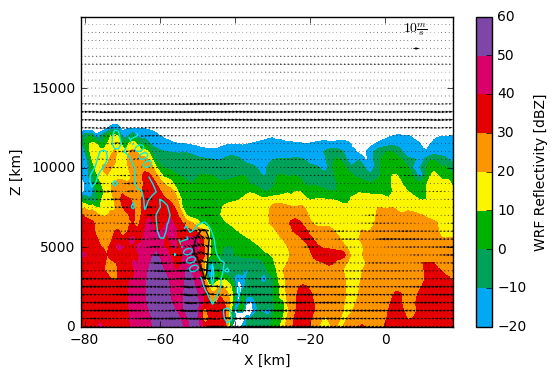

In [29]:
w_new = w_interp((new_grid_z, new_grid_y, new_grid_x))
v_new = v_interp((new_grid_z, new_grid_y, new_grid_x))
u_new = u_interp((new_grid_z, new_grid_y, new_grid_x))
z_new = z_interp((new_grid_z, new_grid_y, new_grid_x))
bca_wrf = get_bca_wrf(new_grid_x, new_grid_y)
print(u_new.shape)
plt.contourf(new_grid_x[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:], 
            new_grid_z[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:],
            z_new[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:],levels=[-20,-10,0,10,20,30,40,50,60],
            cmap=pyart.graph.cm.NWSRef)
ax = plt.colorbar()
ax.set_label('WRF Reflectivity [dBZ]')
q = plt.quiver(new_grid_x[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:], 
           new_grid_z[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:], 
           v_new[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:], 
           w_new[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:], scale=600)
CS = plt.contour(new_grid_x[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:], 
            new_grid_z[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:],
            w_new[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:],levels=[1,4],
                cmap=pyart.graph.cm.NWSRef)
qk = plt.quiverkey(q, 0.9, 0.9, 10, r'$10  \frac{m}{s}$',
                   fontproperties={'weight': 'bold'})
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('X [km]')
plt.ylabel('Z [km]')

## Compare u,v from WRF vs. PyDDA/Multidop

(41, 81, 106)


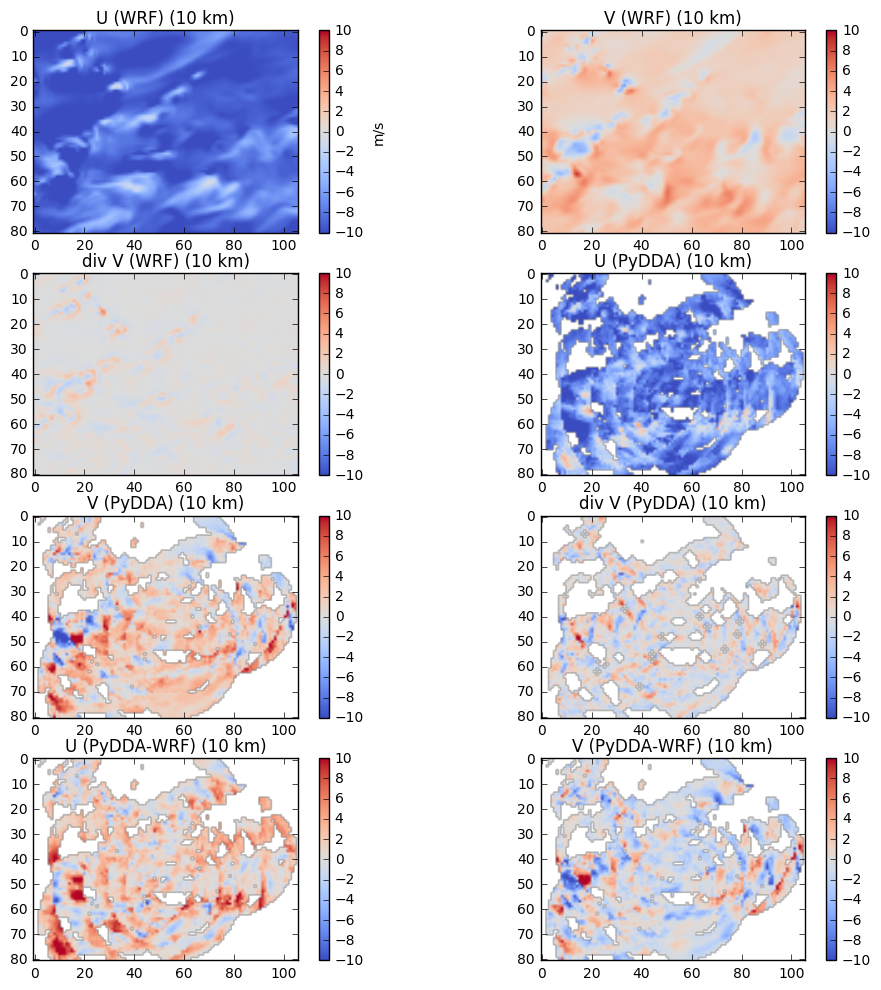

In [19]:
u_pydda = pyart_grid.fields['u']['data']
v_pydda = pyart_grid.fields['v']['data']
y_inds = range(int((cpol_y-50)/scale_down_horiz),int((cpol_y+30)/scale_down_horiz))
x_inds = range(int((cpol_x-55)/scale_down_horiz),int((cpol_x+50)/scale_down_horiz))
print(u_pydda.shape)
u_red = u_new[int((cpol_y-50)/scale_down_horiz):int((cpol_y+31)/scale_down_horiz), 
              int((cpol_x-55)/scale_down_horiz):int((cpol_x+51)/scale_down_horiz),:]
v_red = v_new[int((cpol_y-50)/scale_down_horiz):int((cpol_y+31)/scale_down_horiz), 
              int((cpol_x-55)/scale_down_horiz):int((cpol_x+51)/scale_down_horiz),:]

div_wrf = (np.gradient(u_red, 1.0, axis=1) + 
           np.gradient(v_red, 1.0, axis=0)) 
div_pydda = (np.gradient(u_pydda, 1.0, axis=1) + 
             np.gradient(v_pydda, 1.0, axis=2))

plt.figure(figsize=(12,12))
plt.subplot(421)
plt.imshow(u_red[:,:,20], cmap='coolwarm', vmin=-10, vmax=10)
plt.colorbar(label='m/s')
plt.title('U (WRF) (10 km)')
plt.subplot(422)
plt.imshow(v_red[:,:,20], cmap='coolwarm', vmin=-10, vmax=10)
plt.title('V (WRF) (10 km)')
plt.colorbar()
plt.subplot(423)
plt.imshow(div_wrf[:,:,20], cmap='coolwarm', vmin=-10, vmax=10)
plt.title('div V (WRF) (10 km)')
plt.colorbar()
plt.subplot(424)
plt.imshow(u_pydda[20,:,:], cmap='coolwarm', vmin=-10, vmax=10)
plt.colorbar()
plt.title('U (PyDDA) (10 km)')
plt.subplot(425)
plt.imshow(v_pydda[20,:,:], cmap='coolwarm', vmin=-10, vmax=10)
plt.title('V (PyDDA) (10 km)')
plt.colorbar()
plt.subplot(426)
plt.imshow(div_pydda[20,:,:], cmap='coolwarm', vmin=-10, vmax=10)
plt.title('div V (PyDDA) (10 km)')
plt.colorbar()
plt.subplot(427)
plt.imshow(u_pydda[20,:,:]-u_red[:,:,20], cmap='coolwarm', vmin=-10, vmax=10)
plt.title('U (PyDDA-WRF) (10 km)')
plt.colorbar()
plt.subplot(428)
plt.imshow(v_pydda[20,:,:]-v_red[:,:,20], cmap='coolwarm', vmin=-10, vmax=10)
plt.title('V (PyDDA-WRF) (10 km)')
plt.colorbar()

In [218]:
""" 
    double CalcTermVel(double refl, double z) {

    // Method provided by Mike Biggerstaff and Dan Betten

    double A,B,fallspeed,rho;
    double frz=4500;

    if (z < frz) {

        if (refl < 55)      { A=-2.6;  B=.0107; } // rain
        else if (refl < 60) { A=-2.5;  B=.013;  } // graupel
        else                { A=-3.95; B=.0148; } // hail

    }

    else {

        if (refl < 33)       { A=-.817; B=.0063; } // ice
        else if (refl < 49)  { A=-2.5;  B=.013; } // graupel
        else                 { A=-3.95; B=.0148; } // hail

    }
"""
cpol_origin = np.array([56, 100])-87
berr_origin = np.array([56, 74])-87
def get_sim_rad_vel(u, v, w, x, y, z, origin, ref, fallspeed=True):
    rad_range = np.sqrt(np.square(x-origin[0]) + np.square(y-origin[1]))
    slant_range, el = multidop.angles.rsl_get_slantr_and_elev(rad_range, z/1e3)
    el = el*np.pi/180
    az = np.arctan2((x-origin[0]),(y-origin[1]))
    #az[az < 0] = 2*np.pi + az[az < 0]  
    #az = az * 180/np.pi
    u_a = np.cos(el)*np.sin(az)*u
    v_a = np.cos(el)*np.cos(az)*v
    
    # Calculate fall speeed
    A = np.zeros(ref.shape)
    B = np.zeros(ref.shape)
    rho = np.exp(-z/10000.0)
    frz = 4500
    A[np.logical_and(z < frz, ref < 55)] = -2.6
    B[np.logical_and(z < frz, ref < 55)] = 0.0107
    A[np.logical_and(z < frz,
                     np.logical_and(ref >= 55, ref < 60))] = -2.5
    B[np.logical_and(z < frz,
                     np.logical_and(ref >= 55, ref < 60))] = 0.013
    A[np.logical_and(z < frz, ref > 60)] = -3.95
    B[np.logical_and(z < frz, ref > 60)] = 0.0148
    A[np.logical_and(z > frz, ref < 33)] = -0.817
    B[np.logical_and(z > frz, ref < 33)] = 0.0063
    A[np.logical_and(z > frz,
                     np.logical_and(ref >= 55, ref < 49))] = -2.5
    B[np.logical_and(z > frz,
                     np.logical_and(ref >= 55, ref < 49))] = 0.013
    A[np.logical_and(z > frz, ref > 49)] = -3.95
    B[np.logical_and(z > frz, ref > 49)] = 0.0148
    w_t = A*np.power(10, ref*B)*np.power(1.2/rho, 0.4)
    if(fallspeed == True):
        # Vertical component
        w_a = np.sin(el)*(w-np.abs(w_t))
    else:
        w_a = np.sin(el)*w
    
    v_r = u_a + v_a + w_a
    v_r = np.ma.masked_where(np.logical_or(el < 0.5*np.pi/180,
                                           el > 60.0*np.pi/180), v_r)
    return v_r, el*180/np.pi, az*180/np.pi

/home/rjackson/anaconda3/lib/python3.5/site-packages/MultiDop-0.3-py3.5.egg/multidop/angles.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/MultiDop-0.3-py3.5.egg/multidop/angles.py:24: RuntimeWarning: invalid value encountered in arccos
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:66: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:67: RuntimeWarning: invalid value encountered in greater


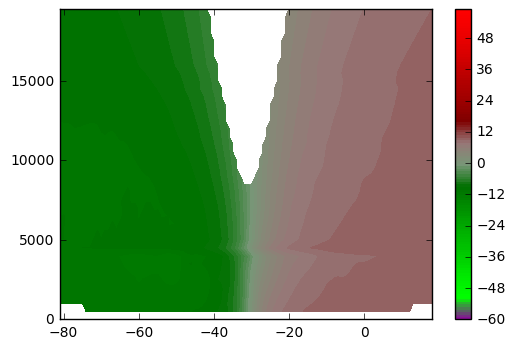

In [219]:
vr_cpol, el, az = get_sim_rad_vel(10*np.ones(u_new.shape), np.ones(u_new.shape), 0*np.ones(u_new.shape), 
                                  new_grid_x, new_grid_y, new_grid_z, cpol_origin, z_new)
plt.contourf(new_grid_x[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:], 
            new_grid_z[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:],
            vr_cpol[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:],levels=np.arange(-60,60,1),
            cmap=pyart.graph.cm.NWSVel)
plt.colorbar()

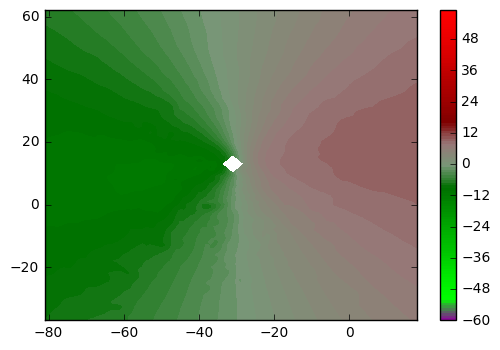

In [220]:
plt.contourf(new_grid_x[int((cpol_y-50)/scale_down_horiz):int((cpol_y+50)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),7], 
            new_grid_y[int((cpol_y-50)/scale_down_horiz):int((cpol_y+50)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),7],
            vr_cpol[int((cpol_y-50)/scale_down_horiz):int((cpol_y+50)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),7],levels=np.arange(-60,60,1),
            cmap=pyart.graph.cm.NWSVel)
plt.colorbar()

/home/rjackson/anaconda3/lib/python3.5/site-packages/MultiDop-0.3-py3.5.egg/multidop/angles.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/MultiDop-0.3-py3.5.egg/multidop/angles.py:24: RuntimeWarning: invalid value encountered in arccos
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:66: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:67: RuntimeWarning: invalid value encountered in greater


/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


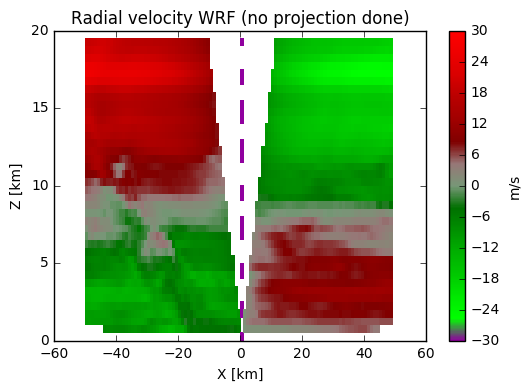

In [310]:
vr_cpol, el, az = get_sim_rad_vel(u_new, v_new, w_new, new_grid_x, new_grid_y, new_grid_z, cpol_origin, z_new)
wt_cpol, el, az = get_sim_rad_vel(u_new, v_new, w_new, new_grid_x, new_grid_y, new_grid_z, cpol_origin, z_new, fallspeed=False)
vr_cpol = vr_cpol
#vr_cpol = np.ma.masked_where(z_new < -40, vr_cpol)
plt.pcolormesh(new_grid_x[int((cpol_y)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:]-cpol_origin[0], 
            new_grid_z[int((cpol_y)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:]/1e3,
            vr_cpol[int((cpol_y)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:],
            cmap=pyart.graph.cm.NWSVel, vmin=-30, vmax=30)
plt.colorbar(label = 'm/s')
plt.title('Radial velocity WRF (no projection done)')
plt.xlabel('X [km]')
plt.ylabel('Z [km]')

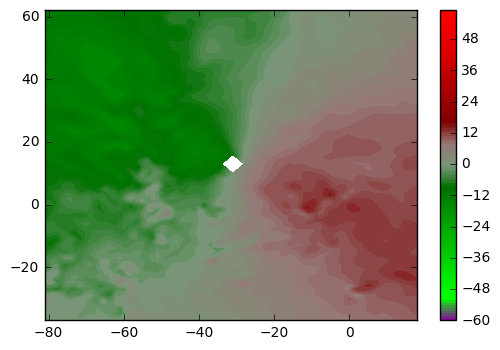

In [294]:
vr_cpol = vr_cpol
#vr_cpol = np.ma.masked_where(z_new < -20, vr_cpol)
plt.contourf(new_grid_x[int((cpol_y-50)/scale_down_horiz):int((cpol_y+50)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),7], 
             new_grid_y[int((cpol_y-50)/scale_down_horiz):int((cpol_y+50)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),7],
             vr_cpol[int((cpol_y-50)/scale_down_horiz):int((cpol_y+50)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),7],levels=np.arange(-60,60,1),
             cmap=pyart.graph.cm.NWSVel)
plt.colorbar()

In [188]:
plt.contourf(new_grid_x[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:]-cpol_origin[0], 
            new_grid_z[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:],
            w_t[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:],levels=np.arange(-30,30,1),
            cmap=pyart.graph.cm.NWSVel)
plt.colorbar()

NameError: name 'w_t' is not defined

In [225]:
vr_wrf = np.transpose(vr_cpol[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:])
vr_sim = grid_cpol.fields['VT']['data'][1:,45,5:105]
print(vr_wrf.shape)
print(vr_sim.shape)
print(grid_cpol.fields['VT']['data'].shape)
plt.contourf(new_grid_x[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:]-cpol_origin[0],
               new_grid_z[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:],
               np.transpose(vr_wrf-vr_sim), cmap='bwr', levels=np.arange(-15,15,0.5))
plt.colorbar(label='WRF $v_{r}$ - CRSIM $v_{r}$')
CS = plt.contour(new_grid_x[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:]-cpol_origin[0],
               new_grid_z[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:],
               z_new[int((cpol_y-5)/scale_down_horiz),int((cpol_x-50)/scale_down_horiz):int((cpol_x+50)/scale_down_horiz),:], cmap=pyart.graph.cm.NWSRef, 
               levels=np.arange(-20, 60, 10))
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('X [km]')

(40, 100)


NameError: name 'vr_sim' is not defined

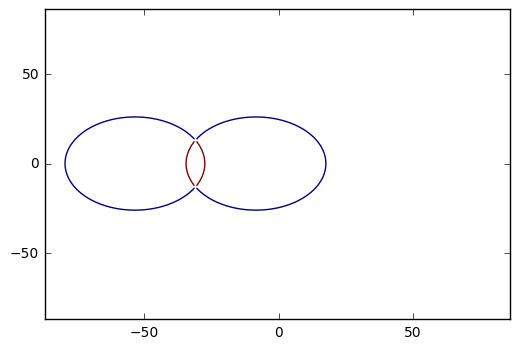

In [437]:
plt.contour(new_grid_x[:,:,0], new_grid_y[:,:,0], bca_wrf[:,:,0], levels=[pi/6, 5*pi/6])

## Make berrimah and cpol grids from WRF data (no radar projection)

In [323]:
# Get a Radar object given a time period in the CPOL dataset
def convert_wrf_to_grid(wrf_dataset, time_step, origin_latlon, radar_latlon):    
    # The pregridded files are not loadable using read_grid, 
    # so load in the necessary fields and make the Grid object out of them
    FillValue = -32768
    Z_wrf1 = wrf_dataset.variables['REFL_10CM'][time_step]
    Lat_wrf = wrf_dataset.variables['XLAT'][time_step]
    Lon_wrf = wrf_dataset.variables['XLONG'][time_step]
    W_wrf = wrf_dataset.variables['W'][time_step]
    V_wrf = wrf_dataset.variables['V'][time_step]
    U_wrf = wrf_dataset.variables['U'][time_step] 
    PH_wrf = wrf_dataset.variables['PH'][time_step]
    PHB_wrf = wrf_dataset.variables['PHB'][time_step]
    time_str = wrf_dataset.variables['Times'][time_step]
    year_str = time_str[0] + time_str[1] + time_str[2] + time_str[3]
    month_str = time_str[5] + time_str[6]
    day_str = time_str[8] + time_str[9]
    hour_str = time_str[11] + time_str[12]
    minute_str = time_str[14] + time_str[15]
    second_str = time_str[17] + time_str[18]
    
    alt_wrf = np.zeros(PH_wrf.shape)
    array_shape = PH_wrf.shape
    Z_wrf = FillValue*np.ones(array_shape)
    alt_wrf = (PH_wrf+PHB_wrf)/9.81
    alt_wrf[0,:,:] = 0.0
    #Z_wrf = -32768*np.ones(alt_wrf.shape)
    Z_wrf[1:] = Z_wrf1
    Z_wrf = np.ma.masked_where(Z_wrf == FillValue, Z_wrf)
    x = np.arange(-87,87,1)*1e3
    y = np.arange(-87,87,1)*1e3
    z = alt_wrf[:-1,1,1]
    #z = np.arange(0, 20000.0, 500.0)
    w = (W_wrf[:-1,:,:]+W_wrf[1:,:,:])/2.0
    v = (V_wrf[:,:-1,:]+V_wrf[:,1:,:])/2.0
    u = (U_wrf[:,:,:-1]+U_wrf[:,:,1:])/2.0
    dBZ = Z_wrf[:-1,:,:]
    
    # Add grid locations
        
    H_mean = np.zeros(array_shape[0])
    for i in range(0, array_shape[0]-1):
        H_mean[i] = np.nanmean(alt_wrf[i,:,:])
    grid_x = {'data': x}
    grid_y = {'data': y}
    levs = {'data': np.arange(0.0, 20000.0, 500.0)} 
    
    w_interp = RegularGridInterpolator((z, y, x), w)
    v_interp = RegularGridInterpolator((z, y, x), v)
    u_interp = RegularGridInterpolator((z, y, x), u)
    z_interp = RegularGridInterpolator((z, y, x), dBZ)
     
    new_grid_z, new_grid_y, new_grid_x = np.meshgrid(levs['data'], grid_y['data'], grid_x['data'], indexing='ij')

    w_new = w_interp((new_grid_z, new_grid_y, new_grid_x))
    v_new = v_interp((new_grid_z, new_grid_y, new_grid_x))
    u_new = u_interp((new_grid_z, new_grid_y, new_grid_x))
    z_new = z_interp((new_grid_z, new_grid_y, new_grid_x))
    
    # Place into dictionary
    W_wrf = {'data': w_new,
             'long_name': 'updraft_velocity',
             'units': 'm/s',
             '_FillValue': FillValue,
             'missing_value': FillValue}
    
    U_wrf = {'data': u_new,
             'long_name': 'zonal_velocity',
             'units': 'm/s',
             '_FillValue': FillValue,
             'missing_value': FillValue}
    
    V_wrf = {'data': v_new,
             'long_name': 'meridional_velocity',
             'units': 'm/s',
             '_FillValue': FillValue,
             'missing_value': FillValue}
    
    Z_wrf = {'data': z_new,
             'long_name': 'reflectivity',
             'units': 'dBZ',
             '_FillValue': FillValue,
             'missing_value': FillValue}
    
    radar_x, radar_y = pyart.core.transforms.geographic_to_cartesian_aeqd(radar_latlon[1], radar_latlon[0], 
                                                                          origin_latlon[1], origin_latlon[0])
    print('Radar located at: ' + str(radar_x) + ',' + str(radar_y))
    vr_wrf, el_wrf, az_wrf = get_sim_rad_vel(U_wrf['data'], V_wrf['data'], W_wrf['data'], new_grid_x/1e3, 
                                             new_grid_y/1e3, new_grid_z, 
                                             np.array([radar_x, radar_y])/1e3, 
                                             Z_wrf['data'])

    vel_wrf = {'data': vr_wrf,
               'long_name': 'radial velocity',
               'units': 'm/s',
               '_FillValue': FillValue,
               'missing_value': FillValue}  
    el_wrf = {'data': el_wrf,
               'long_name': 'elevation',
               'units': 'degrees',
               '_FillValue': FillValue,
               'missing_value': FillValue}  
    az_wrf = {'data': az_wrf,
               'long_name': 'azimuth',
               'units': 'degrees',
               '_FillValue': FillValue,
               'missing_value': FillValue}  
    
    # Lat, lon same everywhere
    cpol_location = origin_lat_lon
    print(cpol_location)
    print(vr_wrf.shape)
    print(el_wrf['data'].shape)
    print(U_wrf['data'].shape)
    print(V_wrf['data'].shape)
    print(W_wrf['data'].shape)
    print(Z_wrf['data'].shape)
    print(x.shape)
    print(y.shape)
    # Add grid fields
    cpol_grid_fields = {'U': U_wrf,
                        'V': V_wrf,
                        'W': W_wrf,
                        'velocity': vel_wrf,
                        'EL': el_wrf,
                        'AZ': az_wrf,
                        'reflectivity': Z_wrf}
    
    metadata = {}
    
    
    # Add latitude and longitude entries for each radar
    origin_latitude = {'data': [origin_latlon[0]],
                       'units': 'degrees'}
    origin_longitude = {'data': [origin_latlon[1]],
                        'units': 'degrees'}
    cpol_latitude = {'data': [radar_latlon[0]],
                       'units': 'degrees'}
    cpol_longitude = {'data': [radar_latlon[1]],
                        'units': 'degrees'}
    origin_altitude = {'data': [50.],
                       'units': 'meters'}
    cpol_altitude = {'data': [50.],
                       'units': 'meters'}
    cpol_name = {'data': 'W'} 
    print(second_str)
    time_dict = {'units': ('seconds since ' + 
                           year_str.decode("utf-8") + 
                           '-' + 
                           month_str.decode("utf-8") + 
                           '-' + 
                           day_str.decode("utf-8") + 
                           'T' + 
                           hour_str.decode("utf-8") + 
                           ':' + 
                           minute_str.decode("utf-8") + 
                           ':' +
                           second_str.decode("utf-8") + 'Z'), 
                 'long_name': 'Time of grid', 'standard_name': 
                 'time', 'data': np.array([0.], dtype=float), 
                 'calendar': 'gregorian'}
    print(time_dict['units'])
    
    # Create grid objects
    grid_wrf = pyart.core.Grid(time_dict, 
                               cpol_grid_fields,
                               metadata,
                               origin_latitude,
                               origin_longitude,
                               origin_altitude,
                               grid_x, 
                               grid_y,
                               levs, 
                               radar_latitude=cpol_latitude,
                               radar_longitude=cpol_longitude,
                               radar_altitude=cpol_altitude,
                               radar_name=cpol_name,
                               radar_time=time_dict)
    return grid_wrf

In [74]:
dset = Dataset(berr_wrf_path)
(dset.variables['y_scene'][:].round(1)-87e3)

array([-87000., -86000., -85000., -84000., -83000., -82000., -81000.,
       -80000., -79000., -78000., -77000., -76000., -75000., -74000.,
       -73000., -72000., -71000., -70000., -69000., -68000., -67000.,
       -66000., -65000., -64000., -63000., -62000., -61000., -60000.,
       -59000., -58000., -57000., -56000., -55000., -54000., -53000.,
       -52000., -51000., -50000., -49000., -48000., -47000., -46000.,
       -45000., -44000., -43000., -42000., -41000., -40000., -39000.,
       -38000., -37000., -36000., -35000., -34000., -33000., -32000.,
       -31000., -30000., -29000., -28000., -27000., -26000., -25000.,
       -24000., -23000., -22000., -21000., -20000., -19000., -18000.,
       -17000., -16000., -15000., -14000., -13000., -12000., -11000.,
       -10000.,  -9000.,  -8000.,  -7000.,  -6000.,  -5000.,  -4000.,
        -3000.,  -2000.,  -1000.,      0.,   1000.,   2000.,   3000.,
         4000.,   5000.,   6000.,   7000.,   8000.,   9000.,  10000.,
        11000.,  120

In [79]:
# Get a Radar object given a time period in the CPOL dataset
def convert_wrf_to_pyart_grid(file_name, origin_latlon, radar_latlon):    
    # The pregridded files are not loadable using read_grid, 
    # so load in the necessary fields and make the Grid object out of them
   
    wrf_dataset = Dataset(file_name)
    FillValue = wrf_dataset['xlat']._FillValue
     
    grid_x = {'data': dset.variables['x_scene'][:].round(1)-87e3}
    grid_y = {'data': dset.variables['y_scene'][:].round(1)-87e3}
    levs = {'data': np.arange(0.0, 20000.0, 500.0)} 
    new_grid_z, new_grid_y, new_grid_x = np.meshgrid(
        levs['data'], grid_y['data'], grid_x['data'], indexing='ij')
    x = dset.variables['x_scene'][:].round(1)-87e3
    y = dset.variables['y_scene'][:].round(1)-87e3
    z = np.mean(dset.variables['height'][:], axis=(1,2))
    grid_fields = {}
    for the_vars in wrf_dataset.variables.keys():
        if(wrf_dataset[the_vars].dimensions == ('nz', 'ny', 'nx')):
            try:
                fv = wrf_dataset[the_vars]._FillValue
            except:
                fv = FillValue
                
            # Need to regrid onto 500 m grid    
            field_interp = RegularGridInterpolator((z, y, x), wrf_dataset[the_vars][:],
                                                   bounds_error=False, fill_value=fv)
            print(the_vars, new_grid_z.shape)
            temp_dict = {'data': field_interp((new_grid_z, new_grid_y, new_grid_x)),
                         'long_name': wrf_dataset[the_vars].description,
                         'units': wrf_dataset[the_vars].units,
                         '_FillValue': fv,
                         'missing_value': fv}
            var_name = the_vars
            if(var_name == 'elev'):
                var_name = 'EL'
            if(var_name == 'azim'):
                var_name = 'AZ'
            grid_fields[var_name] = temp_dict
            
    time_str = wrf_dataset.WRF_input_file[11:]
    
    year_str = time_str[0] + time_str[1] + time_str[2] + time_str[3]
    month_str = time_str[5] + time_str[6]
    day_str = time_str[8] + time_str[9]
    hour_str = time_str[11] + time_str[12]
    minute_str = time_str[14] + time_str[15]
    second_str = time_str[17] + time_str[18]
    
    # Lat, lon same everywhere
    cpol_location = origin_lat_lon
    
    # Add grid fields
        
    metadata = {}
    
    
    # Add latitude and longitude entries for each radar
    origin_latitude = {'data': [origin_latlon[0]],
                       'units': 'degrees'}
    origin_longitude = {'data': [origin_latlon[1]],
                        'units': 'degrees'}
    cpol_latitude = {'data': [radar_latlon[0]],
                       'units': 'degrees'}
    cpol_longitude = {'data': [radar_latlon[1]],
                        'units': 'degrees'}
    origin_altitude = {'data': [50.],
                       'units': 'meters'}
    cpol_altitude = {'data': [50.],
                       'units': 'meters'}
    cpol_name = {'data': 'W'} 
    print(second_str)
    time_dict = {'units': ('seconds since ' + 
                           year_str + 
                           '-' + 
                           month_str + 
                           '-' + 
                           day_str + 
                           'T' + 
                           hour_str + 
                           ':' + 
                           minute_str + 
                           ':' +
                           second_str + 'Z'), 
                 'long_name': 'Time of grid', 'standard_name': 
                 'time', 'data': np.array([0.], dtype=float), 
                 'calendar': 'gregorian'}
    print(time_dict['units'])
    
    # Create grid objects
    grid_wrf = pyart.core.Grid(time_dict, 
                               grid_fields,
                               metadata,
                               origin_latitude,
                               origin_longitude,
                               origin_altitude,
                               grid_x, 
                               grid_y,
                               levs, 
                               radar_latitude=cpol_latitude,
                               radar_longitude=cpol_longitude,
                               radar_altitude=cpol_altitude,
                               radar_name=cpol_name,
                               radar_time=time_dict)
    return grid_wrf

In [80]:
origin_latitude = -12.249166
origin_longitude = 131.04445
cpol_latitude = origin_latitude
cpol_longitude = origin_longitude-19/69.172
origin_lat_lon = np.array([origin_latitude, origin_longitude])
cpol_lat_lon = np.array([cpol_latitude, cpol_longitude])
berr_latitude = cpol_latitude - (26.0/(40075.0*np.cos(cpol_latitude*np.pi/180)))*360.0
print(cpol_latitude)
print(berr_latitude)
berr_longitude = cpol_longitude
berr_lat_lon = np.array([berr_latitude, berr_longitude])
berr_grid_wrf = convert_wrf_to_pyart_grid(berr_wrf_path, origin_lat_lon, berr_lat_lon)
cpol_grid_wrf = convert_wrf_to_pyart_grid(cpol_wrf_path, origin_lat_lon, cpol_lat_lon)

-12.249166
-12.4881691707
Zhh (40, 174, 174)
DV (40, 174, 174)
SWh (40, 174, 174)
SWt (40, 174, 174)
SWs (40, 174, 174)
SWv (40, 174, 174)
SWtot (40, 174, 174)
DV90 (40, 174, 174)
SWh90 (40, 174, 174)
RWV (40, 174, 174)
Ah (40, 174, 174)
Zmin (40, 174, 174)
temp (40, 174, 174)
rho_d (40, 174, 174)
u (40, 174, 174)
v (40, 174, 174)
w (40, 174, 174)
elev (40, 174, 174)
azim (40, 174, 174)
range (40, 174, 174)
height (40, 174, 174)
wcont (40, 174, 174)
00
seconds since 2006-01-20T00:00:00Z
Zhh (40, 174, 174)
DV (40, 174, 174)
SWh (40, 174, 174)
SWt (40, 174, 174)
SWs (40, 174, 174)
SWv (40, 174, 174)
SWtot (40, 174, 174)
DV90 (40, 174, 174)
SWh90 (40, 174, 174)
RWV (40, 174, 174)
Ah (40, 174, 174)
Zmin (40, 174, 174)
temp (40, 174, 174)
rho_d (40, 174, 174)
u (40, 174, 174)
v (40, 174, 174)
w (40, 174, 174)
elev (40, 174, 174)
azim (40, 174, 174)
range (40, 174, 174)
height (40, 174, 174)
wcont (40, 174, 174)
00
seconds since 2006-01-20T00:00:00Z


In [477]:
origin_latitude = -12.249166
origin_longitude = 131.04445
cpol_latitude = origin_latitude
cpol_longitude = origin_longitude-19/69.172
origin_lat_lon = np.array([origin_latitude, origin_longitude])
cpol_lat_lon = np.array([cpol_latitude, cpol_longitude])
berr_latitude = cpol_latitude - (26.0/(40075.0*np.cos(cpol_latitude*np.pi/180)))*360.0
print(cpol_latitude)
print(berr_latitude)
berr_longitude = cpol_longitude
berr_lat_lon = np.array([berr_latitude, berr_longitude])
cpol_grid_wrf = convert_wrf_to_grid(wrf_cdf, 5, origin_lat_lon, cpol_lat_lon)
berr_grid_wrf = convert_wrf_to_grid(wrf_cdf, 5, origin_lat_lon, berr_lat_lon)

-12.249166
-12.4881691707
Radar located at: [-29847.40761271],[-15.17919193]
[ -12.249166  131.04445 ]
(40, 174, 174)
(40, 174, 174)
(40, 174, 174)
(40, 174, 174)
(40, 174, 174)
(40, 174, 174)
(174,)
(174,)
b'00'
seconds since 2006-01-20T00:50:00Z
Radar located at: [-29820.2035523],[-26591.19000812]
[ -12.249166  131.04445 ]
(40, 174, 174)
(40, 174, 174)
(40, 174, 174)
(40, 174, 174)
(40, 174, 174)
(40, 174, 174)
(174,)
(174,)
b'00'
seconds since 2006-01-20T00:50:00Z


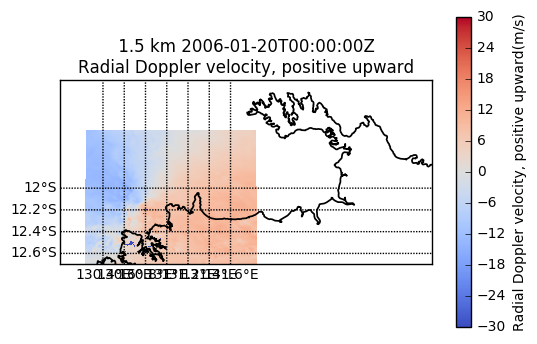

In [67]:
display_berr_grid_wrf = pyart.graph.GridMapDisplay(cpol_grid_wrf)
display_berr_grid_wrf.plot_basemap(min_lat=-12.7, max_lat=-11.0,
                                 min_lon=130.0, max_lon=133.5,
                                 auto_range=False,
                                 lat_lines=[-12.8, -12.6, -12.4, -12.2, -12.0],
                                 lon_lines=[130.4, 130.6, 130.8, 131.0, 131.2, 131.4, 131.6],
                                 resolution='h')
display_berr_grid_wrf.plot_grid('DV', level=3, vmin=-30, vmax=30, cmap='coolwarm')

In [68]:
# The analysis engine currently expects the "missing_value" attribute
pyart.io.write_grid('cpol_wrf.nc', cpol_grid_wrf)
pyart.io.write_grid('berr_wrf.nc', berr_grid_wrf)

/home/rjackson/.local/lib/python3.5/site-packages/pyart/io/cfradial.py:711: UserWarning: Warning, converting non-array to array:origin_latitude
  warnings.warn("Warning, converting non-array to array:%s" % name)
/home/rjackson/.local/lib/python3.5/site-packages/pyart/io/cfradial.py:711: UserWarning: Warning, converting non-array to array:origin_longitude
  warnings.warn("Warning, converting non-array to array:%s" % name)
/home/rjackson/.local/lib/python3.5/site-packages/pyart/io/cfradial.py:711: UserWarning: Warning, converting non-array to array:origin_altitude
  warnings.warn("Warning, converting non-array to array:%s" % name)
/home/rjackson/.local/lib/python3.5/site-packages/pyart/io/cfradial.py:711: UserWarning: Warning, converting non-array to array:radar_latitude
  warnings.warn("Warning, converting non-array to array:%s" % name)
/home/rjackson/.local/lib/python3.5/site-packages/pyart/io/cfradial.py:711: UserWarning: Warning, converting non-array to array:radar_longitude
  warnin

In [159]:
# You don't have to define everything. Most of these keywords are default values.
# If you don't define something the program will provide a default value.
# Check parameters.py for what keyword default values are.
localfile = tempfile.NamedTemporaryFile()
pd = {'dir': './',
      'x': [-87000.0, 1000.0, 174],   # start, step, max = min + (steps-1)
      'y': [-87000.0, 1000.0, 174],
      'z': [0.0, 500.0, 40],
      'grid': [cpol_grid_wrf.origin_longitude['data'][0], cpol_grid_wrf.origin_latitude['data'][0], 50.0],
      'files': ['berr_wrf.nc',
                'cpol_wrf.nc'],
      'radar_names': ['Berrima', 'CPOL'],
      'refl': 'Zhh',  # Name of reflectivity field. Must be common between radars.
      'vt': 'DV',  # Name of velocity field. Must be common between radars.
      'bgfile': 'sounding_file', # Name of sounding file
      'writeout': localfile.name, # Name of output grid file
      'min_cba': 30.0,  # Minimum beam-crossing angle
      'calc_params': 'cpol_calc.dda', # .dda file for parameters related to minimization routine
      'anel': 1, # 0 = Boussinesq approximation for mass conservation, 1 = anelastic 
      'laplace': 0, # 0 = 1st order derivatives for smoothing, 1 = second
      'read_dataweights': 2, # 0 = calculate data constraint weights/output, 1 = read from file, 2 = weigh all equally
      'max_dist': 10.0, # How much distance analysis and observational grid must match in m
      'cutoff': 0.0, # Deny observations below this level from analysis (m)
      'UT': 3.3, # U of prescribed storm motion vector
      'VT': -3.3, # V of prescribed storm motion vector
      'output_error': 0, # 1 = output verification stats after each iteration
      'weak_height': -1, # Sounding height constraint weakened in regions > 10 dBZ below this height (-1 = disabled)
      'upper_bc': 1, # 1 = w = 0 as upper boundary condition, -1 = ignore
      'itmax_frprmn': [200, 10], # max iterations in frprmn function
      'itmax_dbrent': 200, # max iterations in dbrent function
      'C1b': 1.0,  # Data weighting factor
      'C2b': 1500.0,  # Mass continuity weighting factor
      'C3b': 0.0,  # Vorticity weighting factor
      'C4b': 5.0,  # Horizontal smoothing factor
      'C5b': 0.0,  # Vertical smoothing factor
      'C8b': 0.01,  # Sounding factor
      'vary_weights': 0,
      # Define filter with ONE of the following forms.
      # filter: None,
      # filter: filter_frequency Leise nstep
      # filter: filter_frequency low-pass alpha
      'filter': ['60', 'Leise', '2'],
      # Coverage values for various combinations of radars.
      # Each line should provide the type of coverage value, radar count,
      # radar names, and the value, in the following form:
      #
      #   cvg_(""|opt|sub)_(bg|fil): integer radar1 radar2 ... boolean
      #
      # Radars are identified by the OPAWS/OBAN file name with grid data for that
      # radar. This must be just the base name, not the full path.
      #
      # For example:
      #
      #   cvg_opt_bg: SR1 SR2 1
      #
      # says that if SR1 SR2
      # both have data within max_dist meters of the point under consideration,
      # and an optimal beam crossing angle, then the point will receive a coverage
      # value of 1, i.e. point has coverage.
      #
      # "opt" means optimal beam crossing angle.
      # "sub" means suboptimal beam crossing angle.
      # "bg" means background coverage.
      # "fil" means filter coverage.
      # cvg_bg, cvg_fil, and sseq_trip do not require a radar count. (Beam crossing
      # angle is meaningless with one radar, so there is no opt or sub)
      #
      # If this file is being used, coverage values must be provided for all
      # combinations of radars.
      'cvg_opt_bg': [1, 1, 0],
      'cvg_sub_bg': [1, 1, 0],
      'cvg_opt_fil': [0, 0, 0],
      'cvg_sub_fil': [1, 1, 0],
      'cvg_bg': [1, 1, 0],
      'cvg_fil': [0, 0, 0],
      'sseq_trip': [1.0, 1.0, 0.0]
     }
pf = multidop.parameters.ParamFile(pd, 'cpol_test.dda')
pf = multidop.parameters.CalcParamFile(pd, 'cpol_calc.dda')

NameError: name 'cpol_grid_wrf' is not defined

In [160]:
# Unfortunately, text output from the analysis engine (DDA) will not display
# until after the program completes. Expect this step to take several minutes.
bt = time.time()
multidop.execute.do_analysis('cpol_test.dda', cmd_path='/home/rjackson/multidop/src/DDA')
print((time.time()-bt)/60.0, 'minutes to process')

KeyboardInterrupt: 

In [161]:
# Baseline output is not CF or Py-ART compliant. This function fixes that.
# This is why we wrote the original output to a tempfile that can be safely removed.
# The final grid will have all wind solutions outside the coverage region masked.
fname = 'cf_compliant_grid_wrf.nc'
final_grid = multidop.grid_io.make_new_grid([berr_grid_wrf, cpol_grid_wrf], 
                                            localfile.name,
                                            use_mask=True,
                                            min_refl=-20.0)
final_grid.write(fname)
localfile.close()

/home/rjackson/.local/lib/python3.5/site-packages/pyart/io/cfradial.py:711: UserWarning: Warning, converting non-array to array:origin_latitude
  warnings.warn("Warning, converting non-array to array:%s" % name)
/home/rjackson/.local/lib/python3.5/site-packages/pyart/io/cfradial.py:711: UserWarning: Warning, converting non-array to array:origin_longitude
  warnings.warn("Warning, converting non-array to array:%s" % name)
/home/rjackson/.local/lib/python3.5/site-packages/pyart/io/cfradial.py:711: UserWarning: Warning, converting non-array to array:origin_altitude
  warnings.warn("Warning, converting non-array to array:%s" % name)


In [358]:
print(localfile.name)

/tmp/tmpnkka3xr5


In [158]:
fname = 'cf_compliant_grid_wrf.nc'
final_grid = pyart.io.read_grid(fname)
final_grid.fields.keys()

/home/rjackson/.local/lib/python3.5/site-packages/pyart/io/grid_io.py:104: UserWarning: Field eastward_wind skipped due to incorrect shape
  warnings.warn('Field %s skipped due to incorrect shape' % (field))
/home/rjackson/.local/lib/python3.5/site-packages/pyart/io/grid_io.py:104: UserWarning: Field reflectivity skipped due to incorrect shape
  warnings.warn('Field %s skipped due to incorrect shape' % (field))
/home/rjackson/.local/lib/python3.5/site-packages/pyart/io/grid_io.py:104: UserWarning: Field northward_wind skipped due to incorrect shape
  warnings.warn('Field %s skipped due to incorrect shape' % (field))
/home/rjackson/.local/lib/python3.5/site-packages/pyart/io/grid_io.py:104: UserWarning: Field upward_air_velocity skipped due to incorrect shape
  warnings.warn('Field %s skipped due to incorrect shape' % (field))


dict_keys([])

In [162]:
final_grid.fields.keys()
field_dict = {'data': cpol_grid_wrf.fields['reflectivity']['data'],
              'units': 'dBZ',
              'long_name': 'reflectivity',
              'standard_name': 'reflectivity',
              '_FillValue': cpol_grid_wrf.fields['reflectivity']['_FillValue']}
final_grid.add_field('reflectivity', field_dict, replace_existing=True)

KeyError: 'reflectivity'

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in arccos


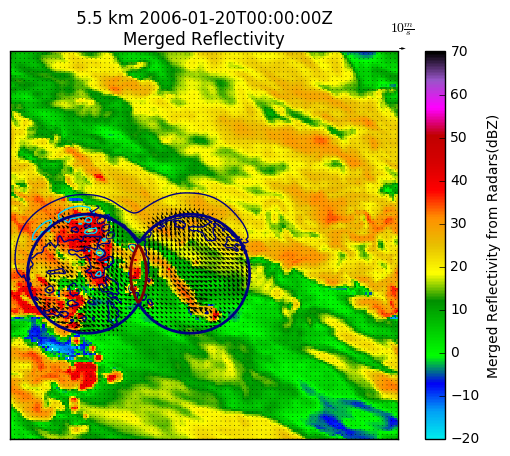

In [163]:
level = 11
fig1 = plt.figure(figsize=(7,5))
CPOLGridDisplay = pyart.graph.GridMapDisplay(final_grid)
#CPOLGridDisplay.plot_basemap(min_lat=-12.8, max_lat=-12.0,
#                             min_lon=130.2, max_lon=131.4,
#                             auto_range=False,
#                             lat_lines=[-12.6, -12.5, -12.4, -12.3, -12.2, -12.0],
#                             lon_lines=[130.6, 130.8, 131.0, 131.2, 131.4],
#                             resolution='h')
CPOLGridDisplay.plot_grid('reflectivity', level, vmin=-20, vmax=70,
                          cmap=pyart.graph.cm.NWSRef)

lons, lats = final_grid.get_point_longitude_latitude(level=level)
v = final_grid.fields['northward_wind']['data'][level,::2,::2]
u = final_grid.fields['eastward_wind']['data'][level,::2,::2]
w = final_grid.fields['upward_air_velocity']['data'][level]
Wcomp = np.amax(final_grid.fields['upward_air_velocity']['data'], axis=0)

q = CPOLGridDisplay.basemap.quiver(lons[::2,::2], lats[::2,::2], 
                                   u, v, 
                                   scale=600,
                                   latlon='True')
qk = plt.quiverkey(q, 1.01, 1.01, 10, r'$10  \frac{m}{s}$',
                   fontproperties={'weight': 'bold'})
CS = CPOLGridDisplay.basemap.contour(lons, lats,
                                     w, latlon='True',
                                     levels=[1, 4, 6, 10])
plt.clabel(CS, inline=1, fontsize=10)

radar1_latlon = np.array([-29799.3,-26573])
radar2_latlon = np.array([-29826.3,-15.157])
bca = get_bca_rads(final_grid, radar1_latlon, radar2_latlon)

CSa = CPOLGridDisplay.basemap.contour(lons, lats,
                                      bca, latlon='True',
                                      levels=[math.pi/6, 5*math.pi/6],
                                      linewidths=2)

(40, 174)
(40, 174)
(40, 174)


(-100, 0)

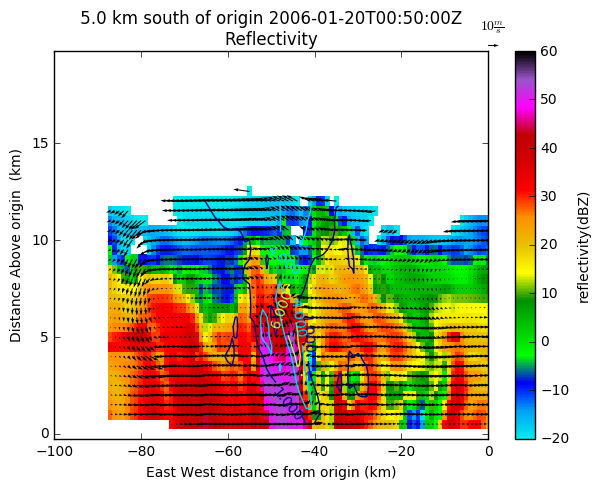

In [521]:
level = 82
fig1 = plt.figure(figsize=(7,5))
CPOLGridDisplay = pyart.graph.GridMapDisplay(final_grid)
final_grid.fields['reflectivity']['data'] = np.ma.masked_where(final_grid.fields['eastward_wind']['data'].mask == True,
                                                               final_grid.fields['reflectivity']['data'])
CPOLGridDisplay.plot_latitudinal_level('reflectivity', level,
                                       cmap=pyart.graph.cm.NWSRef,
                                       vmin=-20, vmax=60)                           

X,Y = np.meshgrid(final_grid.x['data']/1e3, final_grid.z['data']/1e3)
v = final_grid.fields['upward_air_velocity']['data'][:,level,:]
u = final_grid.fields['eastward_wind']['data'][:,level,:]
q = plt.quiver(X[:,:], Y[:,:], u[:,:], v[:,:], scale=400)
qk = plt.quiverkey(q, 1.01, 1.015, 10, r'$10  \frac{m}{s}$',
                   fontproperties={'weight': 'bold'})
print(X.shape)
print(Y.shape)
print(v.shape)
CS = plt.contour(X, Y, v, levels=[1,4,6,10])
plt.clabel(CS, inline=1, fontsize=10)
plt.xlim([-100, 0])

WRF vs CRSIM w p.d.f.s

In [88]:
w = final_grid.fields['upward_air_velocity']['data']
Z = final_grid.fields['reflectivity']['data']
num_levels = 40
times = [0]
ws = np.ma.zeros((len(times), num_levels, 174, 174))
ws_all = np.ma.zeros((len(times), num_levels,  174, 174))
minzs = np.ma.zeros((len(times), num_levels,  174, 174))
maxzs = np.ma.zeros((len(times), num_levels,  174, 174))
Zs = np.ma.zeros((len(times), num_levels,  174, 174))
max_w_individual = []
level_individual = []
label_individual = []
count_individual = []
count = 0
n = 0

## Get all continous regions of W > 1 m s-1 in 3D w array

bca = get_bca(final_grid)
w = final_grid.fields['upward_air_velocity']['data']
Z = final_grid.fields['reflectivity']['data']
w_all = deepcopy(w)
for levels in range(0,num_levels-1):
    w[levels] = np.ma.masked_where(np.logical_or(np.logical_or(bca < math.pi/6,
                                                               bca > 5*math.pi/6), 
                                                 np.logical_or(w[levels] < 1,
                                                               Z[levels] < -20)), w[levels])
    Z[levels] = np.ma.masked_where(np.logical_or(np.logical_or(bca < math.pi/6,
                                                               bca > 5*math.pi/6), 
                                                 np.logical_or(w[levels] < 1,
                                                               Z[levels] < -200), 
                                                 w[levels] < 1), Z[levels])
    w_all[levels] = np.ma.masked_where(np.logical_or(bca < math.pi/6,
                                                     bca > 5*math.pi/6), 
                                                     w_all[levels])

grid_x = final_grid.point_x['data']
grid_y = final_grid.point_y['data']
grid_z = final_grid.point_z['data']

# Set mask to exclude data outside of updrafts
w_temp = deepcopy(w)
w_temp[~w_temp.mask] = 1
w_temp[w_temp.mask] = 0
w_temp.mask = False

six_connected_structure = [[[0,0,0],
                            [0,1,0],
                            [0,0,0]],
                           [[0,1,0],
                            [1,1,1],
                            [0,1,0]],
                           [[0,0,0],
                            [0,1,0],
                            [0,0,0]]]

updrafts, num_updrafts = ndimage.measurements.label(w_temp, 
                                                    structure=six_connected_structure)

# Get statistics in continous regions
index=np.arange(0, num_updrafts + 1)
max_z = ndimage.measurements.maximum(grid_z, 
                                     labels=updrafts, 
                                     index=index)
min_z = ndimage.measurements.minimum(grid_z, 
                                     labels=updrafts,
                                     index=index)

deep_cores = np.where(np.logical_and(max_z >= 15000, min_z <= 1000))
depth = max_z-min_z

max_z_olevel = np.ma.zeros(( 174, 174))
min_z_olevel = np.ma.zeros(( 174, 174))
max_z_level = np.ma.zeros((num_levels,  174, 174))
min_z_level = np.ma.zeros((num_levels,  174, 174))

# Find deep convective cores and get max updraft speeds
for levels in range(0,num_levels-1):
    label_level = updrafts[levels]
    masked_array = np.ma.zeros(updrafts.shape)
    masked_array.mask = True
    w_temp = w[levels]

    for labels in range(1, len(max_z)-1):
        indicies = np.ma.where(label_level == labels)                                
        max_z_olevel[indicies] = max_z[labels]
        min_z_olevel[indicies] = min_z[labels]

        if(len(indicies[0]) > 0 
           and max_z[labels] >= 5000 and min_z[labels] <= 1000
           ):
            max_w_individual.append(max(w_temp[indicies]))
            level_individual.append(levels)
            n = n + 1
            label_individual.append(labels)
            count_individual.append(count)

    max_z_level[levels] = max_z_olevel
    min_z_level[levels] = min_z_olevel

ws[count] = w
ws_all[count] = w_all
minzs[count] = min_z_level
maxzs[count] = max_z_level 
Zs[count] = Z
count = count + 1


max_w_individual = np.array(max_w_individual)
level_individual = np.array(level_individual)
label_individual = np.array(label_individual)
count_individual = np.array(count_individual)
updraft_nos = np.zeros(len(count_individual))
updraft_count = 0
for counts in range(0, max(count_individual)):
    labels = label_individual[count_individual == counts]
    for i in np.unique(labels):
        updraft_nos[np.logical_and(count_individual == counts,
                                   label_individual == i)] = updraft_count
        updraft_count = updraft_count + 1
    
print(str(len(max_w_individual[level_individual == 1])) + ' DCCs found')

# Calculate PDF
mean_w_noproj = np.ma.zeros(num_levels)
median_w_noproj = np.ma.zeros(num_levels)
max_w_noproj = np.ma.zeros(num_levels)
mean_z = np.ma.zeros(num_levels)
median_z = np.ma.zeros(num_levels)
max_z = np.ma.zeros(num_levels)
ninety_w_noproj = np.ma.zeros(num_levels)
ninety_five_w_noproj = np.ma.zeros(num_levels)
ninety_nine_w_noproj = np.ma.zeros(num_levels)
total_counts = np.ma.zeros(num_levels)

bins = np.arange(0,40,1)
bins_z = np.arange(0,60,1)
h_bins = np.arange(0, 20000, 500)
w_hist = np.ma.zeros((num_levels, len(bins)-1))
w_hist_all = np.ma.zeros((num_levels, len(bins)-1))
dims = ws.shape

# Make p.d.f.s 
print(num_levels)
updraft_no = 2
for levels in range(0,num_levels):
    w_level = ws[:,levels,:,:]
    z_level = Zs[:,levels,:,:]
    minz_level = minzs[:,levels,:,:]
    maxz_level = maxzs[:,levels,:,:]
    
    ws_in_core = w_level[~w_level.mask]
    minzs_in_core = minz_level[~w_level.mask]
    maxzs_in_core = maxz_level[~w_level.mask]
    max_w_level = ndimage.measurements.maximum(w[levels],
                                               labels=updrafts[levels],
                                               index=index)
    
    mean_w_noproj[levels] = np.ma.mean(max_w_individual[level_individual == levels])
    median_w_noproj[levels] = np.ma.median(max_w_individual[level_individual == levels])
    

    counts, b = np.histogram(ws_in_core, bins=bins)    
    w_hist[levels] = counts

    counts, b = np.histogram(w_level, bins=bins)
    w_hist_all[levels] = counts 
    
    total_counts[levels] = len(max_w_individual[level_individual == levels])
    if(total_counts[levels]  > 0):
        ninety_w_noproj[levels] = np.percentile(max_w_individual[level_individual == levels], 90)
        ninety_five_w_noproj[levels] = np.percentile(max_w_individual[level_individual == levels], 95)
        ninety_nine_w_noproj[levels] = np.percentile(max_w_individual[level_individual == levels], 99)
    else:
        ninety_five_w_noproj[levels] = float('nan')
        ninety_nine_w_noproj[levels] = float('nan')
        ninety_w_noproj[levels] = float('nan')

ValueError: could not broadcast input array from shape (41,81,106) into shape (40,174,174)

In [146]:
w = pyart_grid.fields['w']['data']
Z = pyart_grid.fields['DT']['data']
num_levels = 41
times = [0]
num_x = 81
num_y = 106
ws = np.ma.zeros((len(times), num_levels, num_x, num_y))
ws_all = np.ma.zeros((len(times), num_levels, num_x, num_y))
minzs = np.ma.zeros((len(times), num_levels, num_x, num_y))
maxzs = np.ma.zeros((len(times), num_levels, num_x, num_y))
Zs = np.ma.zeros((len(times), num_levels, num_x, num_y))
max_w_individual = []
level_individual = []
label_individual = []
count_individual = []
count = 0
n = 0

## Get all continous regions of W > 1 m s-1 in 3D w array

bca = get_bca(pyart_grid)
w = pyart_grid.fields['w']['data']
Z = pyart_grid.fields['DT']['data']
w_all = deepcopy(w)
for levels in range(0,num_levels-1):
    w[levels] = np.ma.masked_where(np.logical_or(np.logical_or(bca < math.pi/6,
                                                               bca > 5*math.pi/6), 
                                                 w[levels] < 1), w[levels])
    Z[levels] = np.ma.masked_where(np.logical_or(np.logical_or(bca < math.pi/6,
                                                               bca > 5*math.pi/6), 
                                                 w[levels] < 1), Z[levels])
    w_all[levels] = np.ma.masked_where(np.logical_or(bca < math.pi/6,
                                                     bca > 5*math.pi/6), 
                                                     w_all[levels])

grid_x = pyart_grid.point_x['data']
grid_y = pyart_grid.point_y['data']
grid_z = pyart_grid.point_z['data']

# Set mask to exclude data outside of updrafts
w_temp = deepcopy(w)
w_temp[~w_temp.mask] = 1
w_temp[w_temp.mask] = 0
w_temp.mask = False

six_connected_structure = [[[0,0,0],
                            [0,1,0],
                            [0,0,0]],
                           [[0,1,0],
                            [1,1,1],
                            [0,1,0]],
                           [[0,0,0],
                            [0,1,0],
                            [0,0,0]]]

updrafts, num_updrafts = ndimage.measurements.label(w_temp, 
                                                    structure=six_connected_structure)

# Get statistics in continous regions
index=np.arange(0, num_updrafts + 1)
max_z = ndimage.measurements.maximum(grid_z, 
                                     labels=updrafts, 
                                     index=index)
min_z = ndimage.measurements.minimum(grid_z, 
                                     labels=updrafts,
                                     index=index)

deep_cores = np.where(np.logical_and(max_z >= 15000, min_z <= 1000))
depth = max_z-min_z

max_z_olevel = np.ma.zeros((num_x, num_y))
min_z_olevel = np.ma.zeros((num_x, num_y))
max_z_level = np.ma.zeros((num_levels, num_x, num_y))
min_z_level = np.ma.zeros((num_levels, num_x, num_y))

# Find deep convective cores and get max updraft speeds
for levels in range(0,num_levels-1):
    label_level = updrafts[levels]
    masked_array = np.ma.zeros(updrafts.shape)
    masked_array.mask = True
    w_temp = w[levels]

    for labels in range(1, len(max_z)-1):
        indicies = np.ma.where(label_level == labels)                                
        max_z_olevel[indicies] = max_z[labels]
        min_z_olevel[indicies] = min_z[labels]

        if(len(indicies[0]) > 0 
           and max_z[labels] >= 5000 and min_z[labels] <= 1000
           ):
            max_w_individual.append(max(w_temp[indicies]))
            level_individual.append(levels)
            n = n + 1
            label_individual.append(labels)
            count_individual.append(count)

    max_z_level[levels] = max_z_olevel
    min_z_level[levels] = min_z_olevel

ws[count] = w
ws_all[count] = w_all
minzs[count] = min_z_level
maxzs[count] = max_z_level 
Zs[count] = Z
count = count + 1


max_w_individual = np.array(max_w_individual)
level_individual = np.array(level_individual)
label_individual = np.array(label_individual)
count_individual = np.array(count_individual)
updraft_nos = np.zeros(len(count_individual))
updraft_count = 0
for counts in range(0, max(count_individual)):
    labels = label_individual[count_individual == counts]
    for i in np.unique(labels):
        updraft_nos[np.logical_and(count_individual == counts,
                                   label_individual == i)] = updraft_count
        updraft_count = updraft_count + 1
    
print(str(len(max_w_individual[level_individual == 1])) + ' DCCs found')

# Calculate PDF
mean_w = np.ma.zeros(num_levels)
median_w = np.ma.zeros(num_levels)
max_w = np.ma.zeros(num_levels)
mean_z = np.ma.zeros(num_levels)
median_z = np.ma.zeros(num_levels)
max_z = np.ma.zeros(num_levels)
ninety_w = np.ma.zeros(num_levels)
ninety_five_w = np.ma.zeros(num_levels)
ninety_nine_w = np.ma.zeros(num_levels)
total_counts = np.ma.zeros(num_levels)

bins = np.arange(0,40,1)
bins_z = np.arange(0,60,1)
h_bins = np.arange(0, 20000, 500)
w_hist = np.ma.zeros((num_levels, len(bins)-1))
w_hist_all = np.ma.zeros((num_levels, len(bins)-1))
dims = ws.shape

# Make p.d.f.s 
print(num_levels)
updraft_no = 2
for levels in range(0,num_levels):
    w_level = ws[:,levels,:,:]
    z_level = Zs[:,levels,:,:]
    minz_level = minzs[:,levels,:,:]
    maxz_level = maxzs[:,levels,:,:]
    
    ws_in_core = w_level[~w_level.mask]
    minzs_in_core = minz_level[~w_level.mask]
    maxzs_in_core = maxz_level[~w_level.mask]
    max_w_level = ndimage.measurements.maximum(w[levels],
                                               labels=updrafts[levels],
                                               index=index)
    
    mean_w[levels] = np.ma.mean(max_w_individual[level_individual == levels])
    median_w[levels] = np.ma.median(max_w_individual[level_individual == levels])
    

    counts, b = np.histogram(ws_in_core, bins=bins)    
    w_hist[levels] = counts

    counts, b = np.histogram(w_level, bins=bins)
    w_hist_all[levels] = counts 
    
    total_counts[levels] = len(max_w_individual[level_individual == levels])
    if(total_counts[levels]  > 0):
        ninety_w[levels] = np.percentile(max_w_individual[level_individual == levels], 90)
        ninety_five_w[levels] = np.percentile(max_w_individual[level_individual == levels], 95)
        ninety_nine_w[levels] = np.percentile(max_w_individual[level_individual == levels], 99)
    else:
        ninety_five_w[levels] = float('nan')
        ninety_nine_w[levels] = float('nan')
        ninety_w[levels] = float('nan')

2 DCCs found
41


In [144]:
w = pyart_grid_mdop.fields['upward_air_velocity']['data']
Z = pyart_grid_mdop.fields['reflectivity']['data']
num_levels = 41
times = [0]
ws = np.ma.zeros((len(times), num_levels, num_x, num_y))
ws_all = np.ma.zeros((len(times), num_levels, num_x, num_y))
minzs = np.ma.zeros((len(times), num_levels, num_x, num_y))
maxzs = np.ma.zeros((len(times), num_levels, num_x, num_y))
Zs = np.ma.zeros((len(times), num_levels, num_x, num_y))
max_w_individual = []
level_individual = []
label_individual = []
count_individual = []
count = 0
n = 0

## Get all continous regions of W > 1 m s-1 in 3D w array

bca = get_bca(pyart_grid)
w = pyart_grid_mdop.fields['upward_air_velocity']['data']
Z = pyart_grid_mdop.fields['reflectivity']['data']
w_all = deepcopy(w)
for levels in range(0,num_levels-1):
    w[levels] = np.ma.masked_where(np.logical_or(np.logical_or(bca < math.pi/6,
                                                               bca > 5*math.pi/6), 
                                                 w[levels] < 1), w[levels])
    Z[levels] = np.ma.masked_where(np.logical_or(np.logical_or(bca < math.pi/6,
                                                               bca > 5*math.pi/6), 
                                                 w[levels] < 1), Z[levels])
    w_all[levels] = np.ma.masked_where(np.logical_or(bca < math.pi/6,
                                                     bca > 5*math.pi/6), 
                                                     w_all[levels])

grid_x = pyart_grid.point_x['data']
grid_y = pyart_grid.point_y['data']
grid_z = pyart_grid.point_z['data']

# Set mask to exclude data outside of updrafts
w_temp = deepcopy(w)
w_temp[~w_temp.mask] = 1
w_temp[w_temp.mask] = 0
w_temp.mask = False

six_connected_structure = [[[0,0,0],
                            [0,1,0],
                            [0,0,0]],
                           [[0,1,0],
                            [1,1,1],
                            [0,1,0]],
                           [[0,0,0],
                            [0,1,0],
                            [0,0,0]]]

updrafts, num_updrafts = ndimage.measurements.label(w_temp, 
                                                    structure=six_connected_structure)

# Get statistics in continous regions
index=np.arange(0, num_updrafts + 1)
max_z = ndimage.measurements.maximum(grid_z, 
                                     labels=updrafts, 
                                     index=index)
min_z = ndimage.measurements.minimum(grid_z, 
                                     labels=updrafts,
                                     index=index)

deep_cores = np.where(np.logical_and(max_z >= 15000, min_z <= 1000))
depth = max_z-min_z

max_z_olevel = np.ma.zeros((num_x, num_y))
min_z_olevel = np.ma.zeros((num_x, num_y))
max_z_level = np.ma.zeros((num_levels, num_x, num_y))
min_z_level = np.ma.zeros((num_levels, num_x, num_y))

# Find deep convective cores and get max updraft speeds
for levels in range(0,num_levels-1):
    label_level = updrafts[levels]
    masked_array = np.ma.zeros(updrafts.shape)
    masked_array.mask = True
    w_temp = w[levels]

    for labels in range(1, len(max_z)-1):
        indicies = np.ma.where(label_level == labels)                                
        max_z_olevel[indicies] = max_z[labels]
        min_z_olevel[indicies] = min_z[labels]

        if(len(indicies[0]) > 0 
           and max_z[labels] >= 5000 and min_z[labels] <= 1000
           ):
            max_w_individual.append(max(w_temp[indicies]))
            level_individual.append(levels)
            n = n + 1
            label_individual.append(labels)
            count_individual.append(count)

    max_z_level[levels] = max_z_olevel
    min_z_level[levels] = min_z_olevel

ws[count] = w
ws_all[count] = w_all
minzs[count] = min_z_level
maxzs[count] = max_z_level 
Zs[count] = Z
count = count + 1


max_w_individual = np.array(max_w_individual)
level_individual = np.array(level_individual)
label_individual = np.array(label_individual)
count_individual = np.array(count_individual)
updraft_nos = np.zeros(len(count_individual))
updraft_count = 0
for counts in range(0, max(count_individual)):
    labels = label_individual[count_individual == counts]
    for i in np.unique(labels):
        updraft_nos[np.logical_and(count_individual == counts,
                                   label_individual == i)] = updraft_count
        updraft_count = updraft_count + 1
    
print(str(len(max_w_individual[level_individual == 1])) + ' DCCs found')

# Calculate PDF
mean_w_mdop = np.ma.zeros(num_levels)
median_w_mdop = np.ma.zeros(num_levels)
max_w_mdop = np.ma.zeros(num_levels)
mean_z = np.ma.zeros(num_levels)
median_z = np.ma.zeros(num_levels)
max_z = np.ma.zeros(num_levels)
ninety_w_mdop = np.ma.zeros(num_levels)
ninety_five_w_mdop = np.ma.zeros(num_levels)
ninety_nine_w_mdop = np.ma.zeros(num_levels)
total_counts = np.ma.zeros(num_levels)

bins = np.arange(0,40,1)
bins_z = np.arange(0,60,1)
h_bins = np.arange(0, 20000, 500)
w_hist = np.ma.zeros((num_levels, len(bins)-1))
w_hist_all = np.ma.zeros((num_levels, len(bins)-1))
dims = ws.shape

# Make p.d.f.s 
print(num_levels)
updraft_no = 2
for levels in range(0,num_levels):
    w_level = ws[:,levels,:,:]
    z_level = Zs[:,levels,:,:]
    minz_level = minzs[:,levels,:,:]
    maxz_level = maxzs[:,levels,:,:]
    
    ws_in_core = w_level[~w_level.mask]
    minzs_in_core = minz_level[~w_level.mask]
    maxzs_in_core = maxz_level[~w_level.mask]
    max_w_level = ndimage.measurements.maximum(w[levels],
                                               labels=updrafts[levels],
                                               index=index)
    
    mean_w_mdop[levels] = np.ma.mean(max_w_individual[level_individual == levels])
    median_w_mdop[levels] = np.ma.median(max_w_individual[level_individual == levels])
    

    counts, b = np.histogram(ws_in_core, bins=bins)    
    w_hist[levels] = counts

    counts, b = np.histogram(w_level, bins=bins)
    w_hist_all[levels] = counts 
    
    total_counts[levels] = len(max_w_individual[level_individual == levels])
    if(total_counts[levels]  > 0):
        ninety_w_mdop[levels] = np.percentile(max_w_individual[level_individual == levels], 90)
        ninety_five_w_mdop[levels] = np.percentile(max_w_individual[level_individual == levels], 95)
        ninety_nine_w_mdop[levels] = np.percentile(max_w_individual[level_individual == levels], 99)
    else:
        ninety_five_w_mdop[levels] = float('nan')
        ninety_nine_w_mdop[levels] = float('nan')

        ninety_w_mdop[levels] = float('nan')

2 DCCs found
41


In [147]:
w = np.ma.array(w_new)
array_shape = w.shape
height = np.zeros(array_shape[1:])
#num_levels = array_shape[1]
mean_w_wrf = np.ma.zeros((num_levels))
median_w_wrf = np.ma.zeros((num_levels))
max_w_wrf = np.ma.zeros((num_levels))
height_level = np.ma.zeros((num_levels))
ninety_w_wrf = np.ma.zeros((num_levels))
ninety_five_w_wrf = np.ma.zeros((num_levels))
ninety_nine_w_wrf = np.ma.zeros((num_levels))
w_hist_wrf = np.ma.zeros((num_levels, 
                          len(bins)-1))
w_hist_all = np.ma.zeros((num_levels, 
                          len(bins)-1))
total_counts_wrf = np.ma.zeros((array_shape[1]))


max_w_individual = []
level_individual = []
label_individual = []
count_individual = []
height_individual = []
j = 5
i = 5
## Get all continous regions of W > 1 m s-1 in 3D w array


z = np.ma.array(z_new)
alts = new_grid_z

w_all = deepcopy(w)

for levels in range(0,array_shape[2]):
    if(levels == array_shape[2]-1):
        z_level = levels-1
    else:
        z_level = levels
    w[:,:,levels] = np.ma.masked_where(np.logical_or(np.logical_or(bca_wrf[:,:,levels] < math.pi/6,
                                                               bca_wrf[:,:,levels] > 5*math.pi/6), 
                                                      np.logical_or(w[:,:,levels] < 1, z[:,:,z_level] < 0)), 
                                       w[:,:,levels])
    #w_all[:,:,levels] = w_new[i,levels]
height = alts

grid_z = height

# Set mask to exclude data outside of updrafts
w_temp = deepcopy(w)
w_temp[~w_temp.mask] = 1
w_temp[w_temp.mask] = 0
w_temp.mask = False

six_connected_structure = [[[0,0,0],
                            [0,1,0],
                            [0,0,0]],
                           [[0,1,0],
                            [1,1,1],
                            [0,1,0]],
                           [[0,0,0],
                            [0,1,0],
                            [0,0,0]]]

updrafts, num_updrafts = ndimage.measurements.label(w_temp, 
                                                    structure=six_connected_structure)

# Get statistics in continous regions
index=np.arange(0, num_updrafts + 1)

max_z = ndimage.measurements.maximum(grid_z, 
                                     labels=updrafts, 
                                     index=index)
min_z = ndimage.measurements.minimum(grid_z, 
                                     labels=updrafts,
                                     index=index)
deep_cores = np.where(np.logical_and(max_z >= 15000, min_z <= 5000))

depth = max_z-min_z
max_z_olevel = np.ma.zeros((array_shape[1],
                            array_shape[0]))
min_z_olevel = np.ma.zeros((array_shape[1],
                            array_shape[0]))
max_z_level = np.ma.zeros((array_shape[2],
                           array_shape[1],
                           array_shape[0]))
min_z_level = np.ma.zeros((array_shape[2],
                           array_shape[1],
                           array_shape[0]))

# Find deep convective cores and get max updraft speeds
for levels in range(0,array_shape[2]):
    label_level = updrafts[:,:,levels]
    masked_array = np.ma.zeros(updrafts.shape)
    masked_array.mask = True
    w_temp = w[:,:,levels]
    height_temp = height[:,:,levels]
    for labels in range(1, len(max_z)-1):
        indicies = np.ma.where(label_level == labels)                                
        max_z_olevel[indicies] = max_z[labels]
        min_z_olevel[indicies] = min_z[labels]

        if(len(indicies[0]) > 0  
           and max_z[labels] >= 5000 and min_z[labels] <= 1000):
            max_w_individual.append(max(w_temp[indicies]))
            level_individual.append(levels)
            n = n + 1
            label_individual.append(labels)
            count_individual.append(count)
            height_individual.append(np.mean(height_temp[indicies]))

    max_z_level[levels] = max_z_olevel
    min_z_level[levels] = min_z_olevel

count = count + 1

max_w_individual = np.array(max_w_individual)
level_individual = np.array(level_individual)
label_individual = np.array(label_individual)
count_individual = np.array(count_individual)
height_individual = np.array(height_individual)
updraft_nos = np.zeros(len(count_individual))
updraft_count = 0
print(max_w_individual)
for counts in range(0, max(count_individual)):
    labels = label_individual[count_individual == counts]
    for i in np.unique(labels):
        updraft_nos[np.logical_and(count_individual == counts,
                                   label_individual == i)] = updraft_count
        updraft_count = updraft_count + 1

print(str(len(max_w_individual[level_individual == 1])) + ' DCCs found')

# Calculate PDF   
bins = np.arange(0,40,1)
bins_z = np.arange(0,60,1)
h_bins = np.arange(0, 20000, 500) 
dims = ws.shape

# Make p.d.f.s 
updraft_no = 2
for levels in range(0,array_shape[2]):
    mean_w_wrf[levels] = np.ma.mean(max_w_individual[level_individual == levels])
    median_w_wrf[levels] = np.ma.median(max_w_individual[level_individual == levels])
    height_level[levels] = np.nanmean(height_individual[level_individual == levels])
    counts, b = np.histogram(ws_in_core, bins=bins)    
    w_hist_wrf[levels] = counts

    counts, b = np.histogram(w_level, bins=bins)
    w_hist_all[levels] = counts 

    total_counts_wrf[levels] = len(max_w_individual[level_individual == levels])
    if(len(np.where(level_individual == levels)) > 0):
        ninety_w_wrf[levels] = np.nanpercentile(max_w_individual[level_individual == levels], 90)
        ninety_five_w_wrf[levels] = np.nanpercentile(max_w_individual[level_individual == levels], 95)
        ninety_nine_w_wrf[levels] = np.nanpercentile(max_w_individual[level_individual == levels], 99)
    else:
        ninety_five_w_wrf[levels] = float('nan')
        ninety_nine_w_wrf[levels] = float('nan')
        ninety_w_wrf[levels] = float('nan')

[ 3.03304555  1.44481918  3.12064858  5.27179159  2.73540634  5.50291956
  7.76447861  4.484528    5.4946723   8.78107098  4.7370243   6.75766774
  8.61377452  5.21917664  7.29241065  7.98554385  4.88134568  7.99090166
  7.00000874  4.39325529  8.9674208   8.4648961   7.06553475  9.47397871
  8.5263038   4.84031692 10.43014309  7.62831349  8.17336473  9.99550193
  6.63498775  5.06768165 10.59359033  8.00647589  2.56935996  9.29654079
  9.24201921  9.0243058   9.93068109  8.210336    9.00066219  5.53405033
  5.92190611  4.85388385  6.40006615  3.93605759  3.88835592  3.82364817
  4.27877071  4.75195975  4.06904659  3.48464844  2.30120439]
3 DCCs found


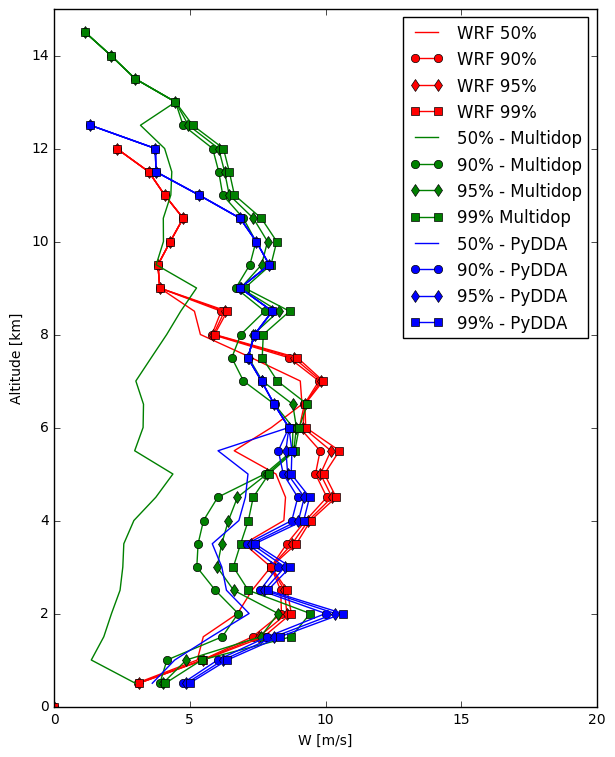

In [148]:
plt.figure(figsize=(7,9))
plt.plot(median_w_wrf, height_level/1e3, color='r')
plt.plot(ninety_w_wrf, height_level/1e3, color='r', marker='o')
plt.plot(ninety_five_w_wrf, height_level/1e3, color='r', marker='d')
plt.plot(ninety_nine_w_wrf, height_level/1e3, color='r', marker='s')

plt.plot(median_w_mdop, np.arange(0,20.5,0.5), color='g')
plt.plot(ninety_w_mdop, np.arange(0,20.5,0.5), color='g', marker='o')
plt.plot(ninety_five_w_mdop, np.arange(0,20.5,0.5), color='g', marker='d')
plt.plot(ninety_nine_w_mdop, np.arange(0,20.5,0.5), color='g', marker='s')

plt.plot(median_w, np.arange(0,20.5,0.5), color='b')
plt.plot(ninety_w, np.arange(0,20.5,0.5), color='b', marker='o')
plt.plot(ninety_five_w, np.arange(0,20.5,0.5), color='b', marker='d')
plt.plot(ninety_nine_w, np.arange(0,20.5,0.5), color='b', marker='s')

legend(['WRF 50%', 'WRF 90%', 'WRF 95%', 'WRF 99%',
        '50% - Multidop', '90% - Multidop', '95% - Multidop', '99% Multidop',
        '50% - PyDDA',
        '90% - PyDDA',
        '95% - PyDDA',
        '99% - PyDDA'], loc='best')
plt.xlim([0,20])
plt.ylim([0,15])
plt.xlabel('W [m/s]')
plt.ylabel('Altitude [km]')

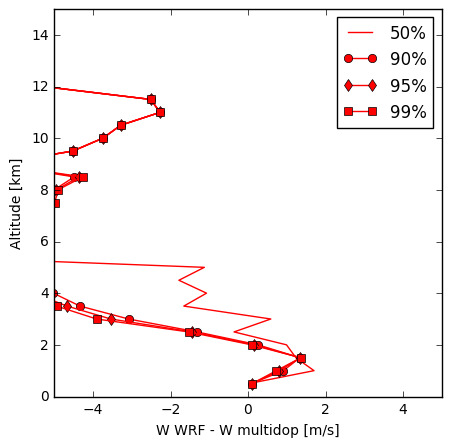

In [189]:
plt.figure(figsize=(5,5))
plt.plot(median_w_wrf-median_w, height_level/1e3, color='r')
plt.plot(ninety_w_wrf-ninety_w, height_level/1e3, color='r', marker='o')
plt.plot(ninety_five_w_wrf-ninety_five_w, height_level/1e3, color='r', marker='d')
plt.plot(ninety_nine_w_wrf-ninety_nine_w, height_level/1e3, color='r', marker='s')
plt.xlim([-5,5])
plt.ylim([0,15])
plt.xlabel('W WRF - W multidop [m/s]')
plt.ylabel('Altitude [km]')
plt.legend(['50%', '90%', '95%', '99%'])

(107, 81, 21)
(87, 37, 20)


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in arccos
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in arccos
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: Run

ValueError: x and y must be the same size

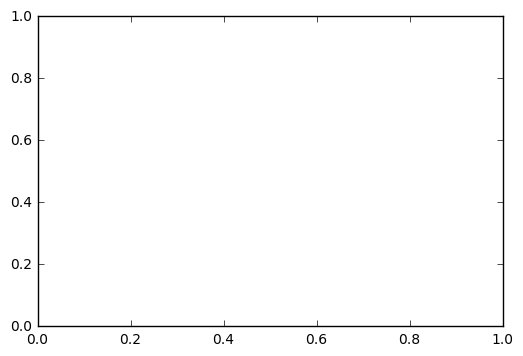

In [734]:
bca = get_bca(pyart_grid)
num_levels = 21
w = pyart_grid.fields['upward_air_velocity']['data']
Z = pyart_grid.fields['reflectivity']['data']
w_all = deepcopy(w)
for levels in range(0,num_levels-1):
    w[levels] = np.ma.masked_where(np.logical_or(np.logical_or(bca < math.pi/6,
                                                               bca > 5*math.pi/6), 
                                                 w[levels] < 1), w[levels])
    Z[levels] = np.ma.masked_where(np.logical_or(np.logical_or(bca < math.pi/6,
                                                               bca > 5*math.pi/6), 
                                                 w[levels] < 1), Z[levels])
    w_all[levels] = np.ma.masked_where(np.logical_or(bca < math.pi/6,
                                                     bca > 5*math.pi/6), 
                                                     w_all[levels])

w_multidop = w_all
j = 4
i = 4
## Get all continous regions of W > 1 m s-1 in 3D w array

w = np.ma.array(w_new)
array_shape = w.shape
z = np.ma.array(z_new)
alts = new_grid_z

for levels in range(0,array_shape[2]):
    if(levels == array_shape[2]-1):
        z_level = levels-1
    else:
        z_level = levels
    w[:,:,levels] = np.ma.masked_where(np.logical_or(np.logical_or(bca_wrf[:,:,levels] < math.pi/6,
                                                                    bca_wrf[:,:,levels] > 5*math.pi/6), 
                                                      np.logical_or(w[:,:,levels] < 1, z[:,:,z_level] < 0)), 
                                       w[:,:,levels])
    
cpol_x = 56
cpol_y = 100
w = w[cpol_x-56:cpol_x+51, cpol_y-50:cpol_y+31, :]
w_multidop = np.transpose(w_multidop[:,:,4:])
print(w_multidop.shape)
print(w.shape)
plt.scatter(w_multidop, np.transpose(w))
plt.xlabel('W retrieval [m/s]')
plt.ylabel('W model [m/s]')
plt.plot([0,10], [0,10])
plt.xlim([0,10])
plt.ylim([0,10])
#xlim=(-60000, 50000), ylim=(-50000, 30000), 